1，数据准备

（1）RNA-seq数据：至少10个

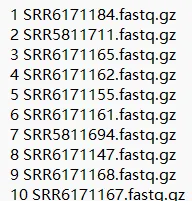



In [ ]:
1 SRR6171184
2 SRR5811711
3 SRR6171165
4 SRR6171162
5 SRR6171155
6 SRR6171161
7 SRR5811694
8 SRR6171147
9 SRR6171168
10 SRR6171167

（2）mapping的人类参考基因组：2个

/lustre/share/class/BIO8402/proj1/chr

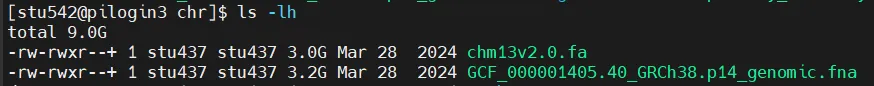

人类参考基因组 (GRCh38.p14)

第一个完整的人类基因组（T2T-CHM13v2. 0)

（3）要评估的3个人类参考基因组注释数据集

/lustre/share/class/BIO8402/proj1/gff 

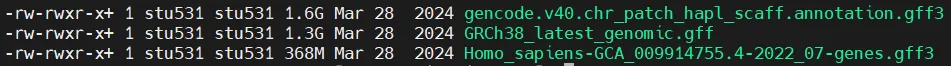

GENCODE人类基因组注释：/data1/project/proj1/gencode.v40.chr_patch_hapl_scaff.annotation.gff3

Refseq注释：/data1/project/proj1/GRCh38_latest_genomic.gff

T2T-CHM13v2.0的1个基因组注释数据集：/data1/project/proj1/Homo_sapiens-GCA_009914755.4-2022_07-genes.gff3

（4）chr抽样：

chr2、7、18、Y

2，part1部分：

已经做的部分：hisat2回帖

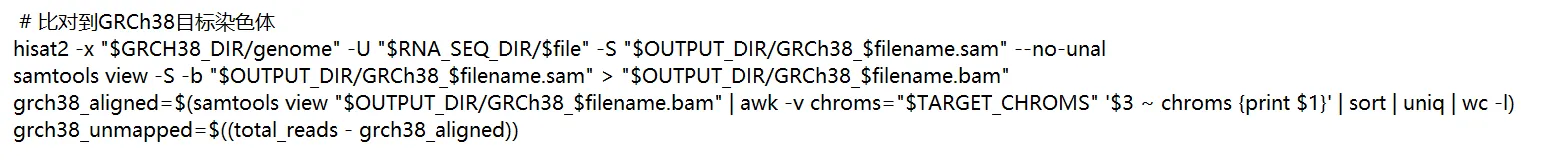

我们假设mapping到sam/转换到bam的这一步没有错：

其中bam的第3、4列是position，第3列是chr，第4列是这个chr上的位置

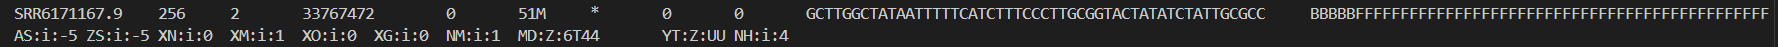

那么我们就直接基于这个bam文件进行分析

2，对数据的一些基本的预处理：

In [ ]:
# bam文件先合并，即10个文件都合并
# bam文件还是要sort & index一下

#!/bin/bash
bam_dir=/data1/project/proj1
genome_dir=(GRCH38 T2T)

for genome in ${genome_dir[@]};do
    samtools merge -@ 20 ${bam_dir}/${genome}/${genome}_merged.bam ${bam_dir}/${genome}/*.bam
    samtools sort ${bam_dir}/${genome}/${genome}_merged.bam -@ 20 -o ${bam_dir}/${genome}/${genome}_merged_sorted.bam
    samtools index -@ 20  ${bam_dir}/${genome}/${genome}_merged_sorted.bam
done

3，执行流程

思路：

注意：每个基因组注释文件应该只用于对应的参考基因组。即：

- GENCODE和RefSeq注释用于GRCh38的比对结果

- T2T注释用于T2T-CHM13v2.0的比对结果

因此，我们实际上需要分析三个注释集，但每个注释集对应不同的参考基因组。具体来说：

- 对于GRCh38参考基因组，我们有两个注释集（GENCODE和RefSeq），因此我们需要用这两个注释集分别分析GRCh38的比对结果。

- 对于T2T参考基因组，我们有一个注释集（Ensembl T2T注释），因此我们用它分析T2T的比对结果。

所以，整个分析流程应该分为三个分支：

分支1：GRCh38比对结果 + GENCODE注释

分支2：GRCh38比对结果 + RefSeq注释

分支3：T2T比对结果 + T2T注释

每个分支都要针对分配的染色体（chr2, chr7, chr18, chrY）进行分析。

另外，每个RNA-seq样本是独立的，所以我们需要对每个样本分别统计，然后合并结果。——》此处我们选择直接merge bam文件，然后分chr2、chr7、chr18、chrY进行分析

因此，层次结构为：

1. 对于每个RNA-seq样本（10个）：

a. 比对到GRCh38 -> 得到BAM文件（GRCh38_sampleX.bam）

b. 比对到T2T -> 得到BAM文件（T2T_sampleX.bam）

2. 对于每个BAM文件，合并之后我们需要分别用对应的注释文件进行分析（三个注释分析分支）。

但是，请注意：每个分支的分析是独立的，而且每个分支的分析需要针对目标染色体进行。

步骤：

1. 比对后，对每个BAM文件提取目标染色体（chr2, chr7, chr18, chrY）的子集，生成新的BAM文件（以减少后续分析的数据量）。

2. 然后，对每个目标染色体子集的BAM文件，使用对应的注释文件进行featureCounts分析（用于统计外显子、外显子连接点等）。

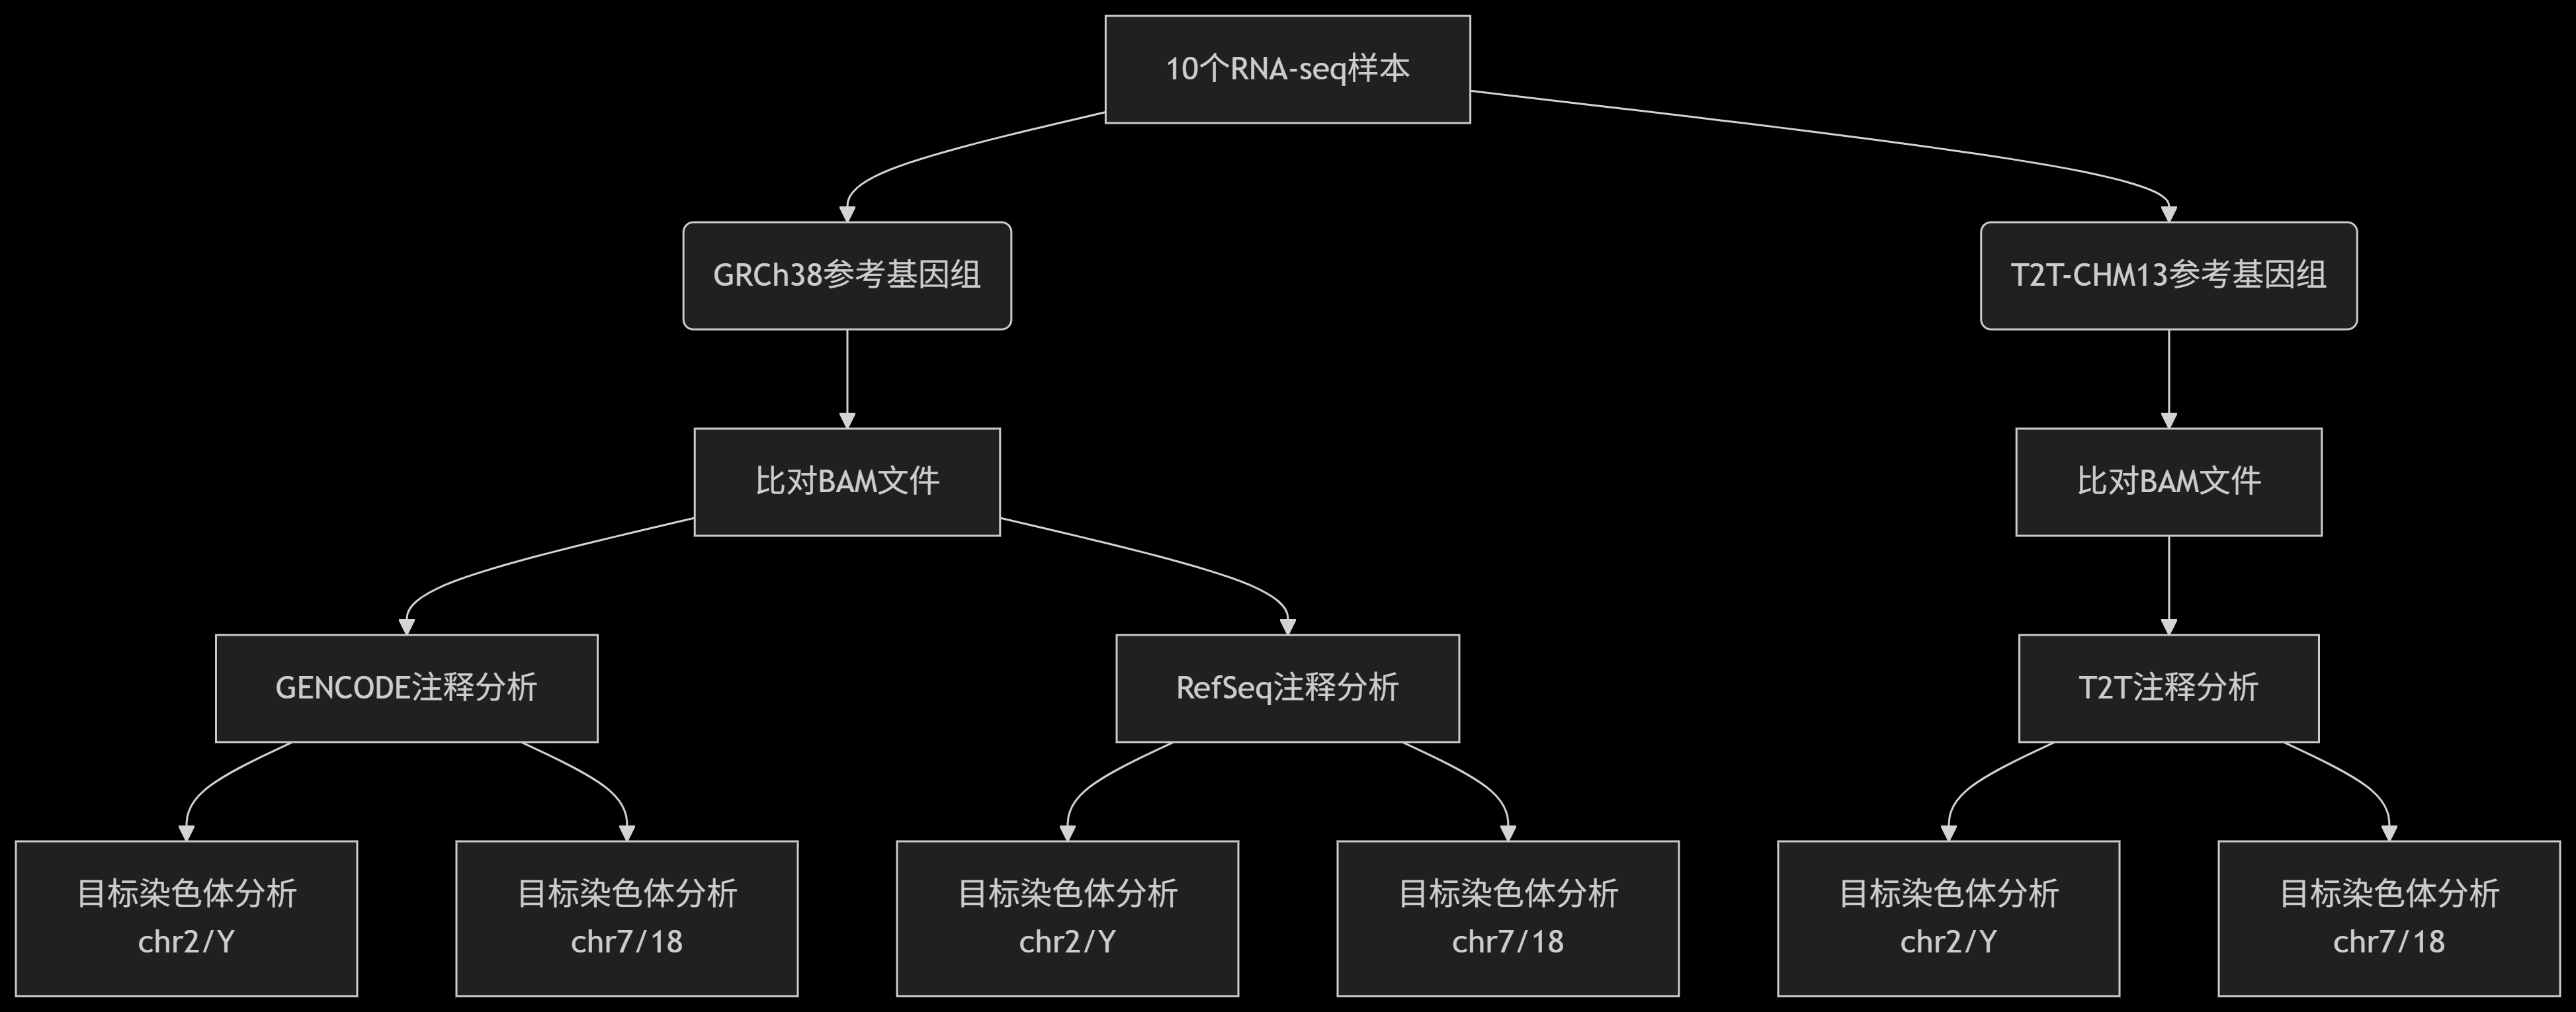

4，提取chr子集

手头上有10个RNA-seq的bam文件，按照前面的说法都merge之后，且sort & index过了


In [ ]:
# 提取出2、7、18、Y染色体的bam文件
# 可以合并在一起，没必要分别提取出来，因为每个bam评估都是整体的
# 后续有需求可以分开来提取
# T2T中是chr2, chr7, chr18, chrY，分开来处理同理

#!/bin/bash
bam_dir=/data1/project/proj1

for bam in ${bam_dir}/GRCH38/*_sorted.bam;do
    prefix=$(basename ${bam} .bam)
    samtools view -b -h ${bam} 2 > ${bam_dir}/GRCH38/${prefix}_2.bam
    samtools view -b -h ${bam} 7 > ${bam_dir}/GRCH38/${prefix}_7.bam
    samtools view -b -h ${bam} 18 > ${bam_dir}/GRCH38/${prefix}_18.bam
    samtools view -b -h ${bam} Y > ${bam_dir}/GRCH38/${prefix}_Y.bam
    samtools index -@ 15 ${bam_dir}/GRCH38/${prefix}_(2|7|18|Y).bam
done


for bam in ${bam_dir}/T2T/*_sorted.bam;do
    prefix=$(basename ${bam} .bam)
    samtools view -b -h ${bam} chr2 > ${bam_dir}/T2T/${prefix}_chr2.bam
    samtools view -b -h ${bam} chr7 > ${bam_dir}/T2T/${prefix}_chr7.bam
    samtools view -b -h ${bam} chr18 > ${bam_dir}/T2T/${prefix}_chr18.bam
    samtools view -b -h ${bam} chrY > ${bam_dir}/T2T/${prefix}_chrY.bam
    samtools index -@ 15 ${bam_dir}/T2T/${prefix}_(chr2|chr7|chr18|chrY).bam
done


5，分层运行featureCounts

gencode.v40.chr_patch_hapl_scaff.annotation.gff3

1个gene，后面transcript，跟着不同exon

第3列的是feature type，3个基本上都有exon和gene，就这两个feature

In [ ]:
# gff转换为gtf文件
# metafeature需要保留gene_id和exon_id的信息
!gffread gencode.v40.chr_patch_hapl_scaff.annotation.gff3 -T -F --keep-genes --keep-exon-attrs -o gencode.gtf
!gffread GRCh38_latest_genomic.gff  -T -F --keep-genes --keep-exon-attrs -o GRCh38.gtf
!gffread Homo_sapiens-GCA_009914755.4-2022_07-genes.gff3 -T -F --keep-genes --keep-exon-attrs -o T2T.gtf

feature只看gene以及exon，meta_feature是gene_id或exon_id

T2T.gtf有transcript_id、gene_id、exon_id

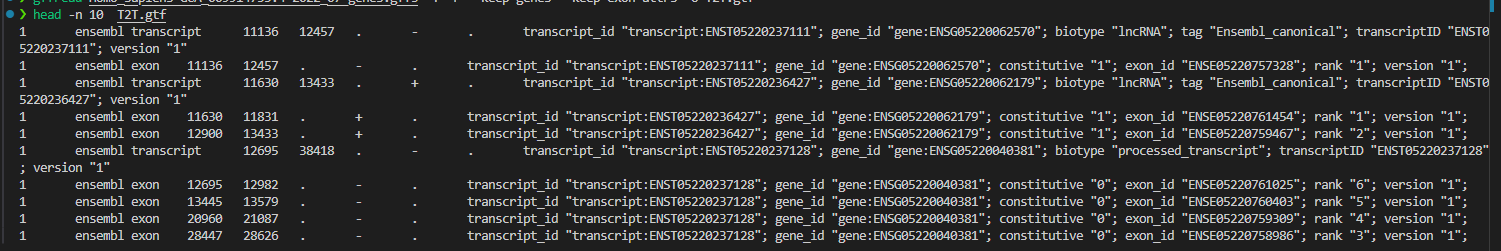

GRCh38.gtf有transcript_id、gene_id

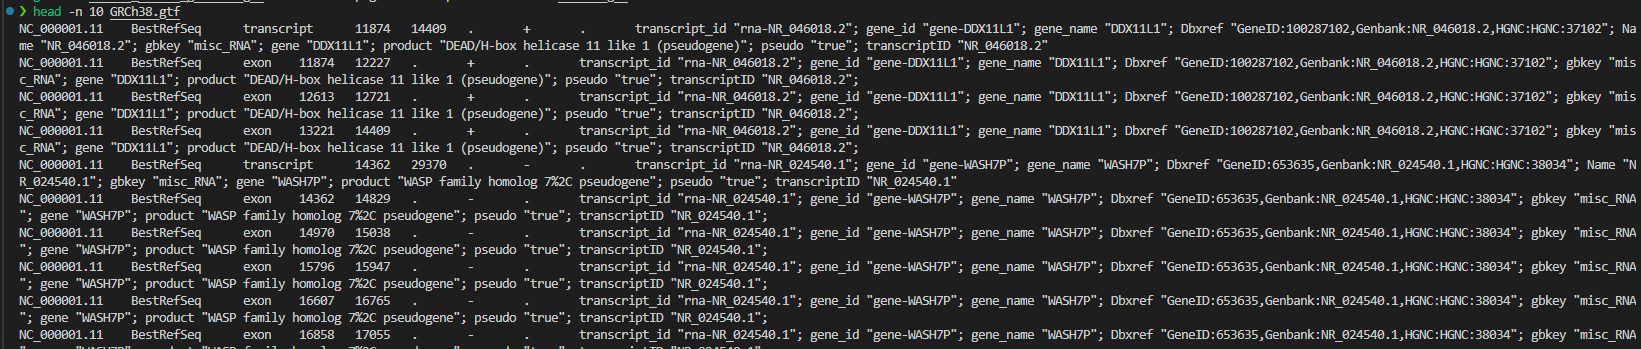

gencode.gtf有transcript_id、gene_id、exon_id

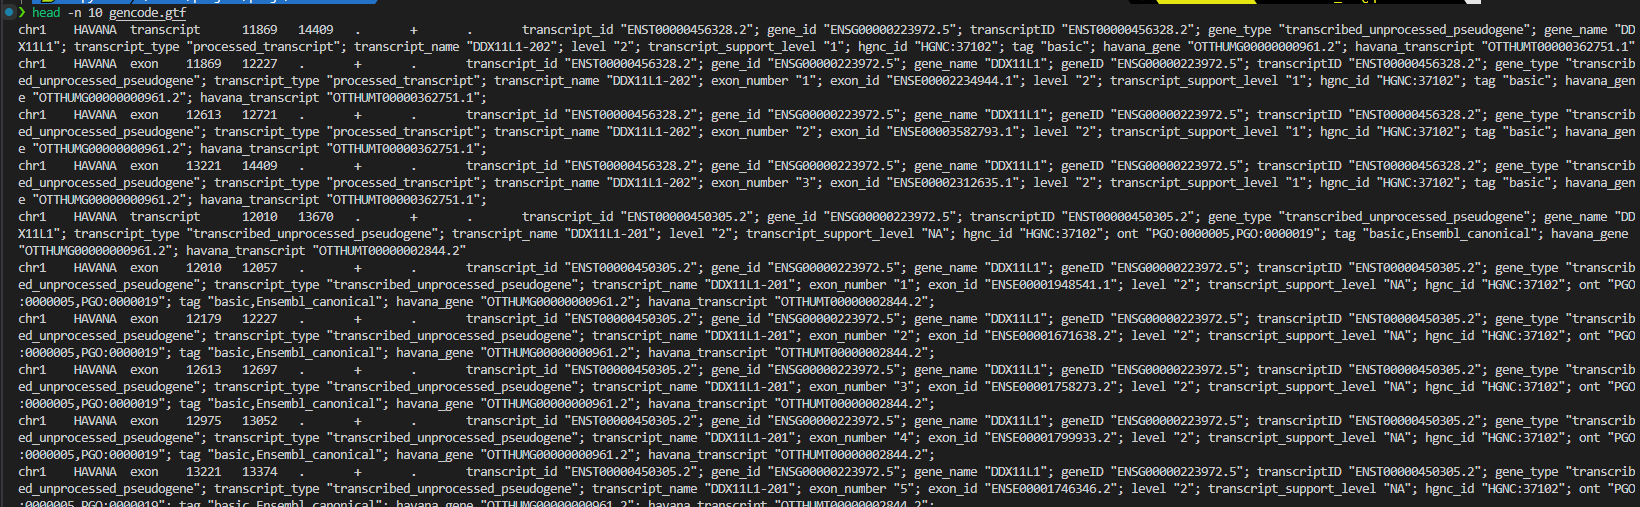

（1）GRCh38比对结果 + GENCODE注释

GRCH比对的结果：/data1/project/proj1/GRCH38/*_sorted_(2|7|18|Y).bam

GENCODE注释是：/data1/project/proj1/annotations/gencode.gtf

该注释中第3列的feature type有gene、exon、transcript，最后1列的attribute有gene_id/transcript_id/exon_id

第1列是chr，而我们的bam里是2、7、18、Y，所以需要对应-A alias文件如下

In [6]:
!echo -e "chr2,2\nchr7,7\nchr18,18\nchrY,Y" > chr_alias.txt

It calls a hit if any overlap is found between read and feature.
When counting reads at meta-feature level, a hit is called for a meta-feature if the read  overlaps any component feature of the meta-feature.  Note that if a read hits a meta-feature,  it is always counted once no matter how many features in the meta-feature this read overalps  with.

-t是选择feature，-g选择meta-feature

-f选择定量的水平，即在什么水平上定量，如果选择了-f，那就是在feature上定量；不选，就是在meta-feature上定量，依据前面的说法

然后-O是允许多重比对，即当一个read比对到多个feature或多个metafeature的时候，这条read会被统计多次，

我们这里的场景明显就是1个gene内多个exon，算作多个feature，如果1个reads被比对到2个exon、3个exon、4个等等，会被统计2、3、4次，

当然，我们不需要这样的场景，bam里的每条reads，与1个feature重叠（它可能是split，或者inside 1个exon内我们不管），但是结果肯定是这个read被count 1次，我们不-O

所以我们

-t exon -g gene_id -f -J (其实-g是无所谓的，而且因为我们很多的注释文件里feature上是有exon，但是meta feature很多都不一样，所以-g依据具体文件而定，所以还是-f保险)

需要明确的是，我们是对exon这个feature进行定量，所以

我们可以 -t exon -g exon_id，这个时候-f不-f没区别，因为都是exon

或者-t exon -g gene_id -f 这个时候就是exon上定量了

In [ ]:
#!/bin/bash

# 主要是-f选项

featureCounts -T 20 -a /data1/project/proj1/annotations/gencode.gtf \
    -o /data1/project/proj1/result/grch38_gencode_exon_counts.txt  \
        -t exon -f  \
        -g  gene_id \
        -R CORE --Rpath /data1/project/proj1/result  \
        -J -A /data1/project/proj1/chr_alias.txt /data1/project/proj1/GRCH38/*.bam

首先总的bam在不同注释中是不会变化的：
total alignments，如果不考虑multi mappnig，基本上和total reads接近

assigned是不包括multi mapping的，所以暂且认为是所有hit到feature即和exon有overlap而被count进去的

GRCH38_merged_sorted_18.bam
Total alignments : 1533923                                              
Successfully assigned alignments : 177110 (11.5%)                     

GRCH38_merged_sorted_2.bam
Total alignments : 7583435                                            
Successfully assigned alignments : 884752 (11.7%) 


GRCH38_merged_sorted_7.bam
Total alignments : 6416588                                          
Successfully assigned alignments : 587538 (9.2%)  

GRCH38_merged_sorted_Y.bam
Total alignments : 271309    
Successfully assigned alignments : 6281 (2.3%)                        

In [ ]:
nohup: ignoring input

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.1.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                                                                            ||
||                           GRCH38_merged_sorted_18.bam                      ||
||                           GRCH38_merged_sorted_2.bam                       ||
||                           GRCH38_merged_sorted_7.bam                       ||
||                           GRCH38_merged_sorted_Y.bam                       ||
||                                                                            ||
||             Output file : grch38_gencode_exon_counts.txt                   ||
||                 Summary : grch38_gencode_exon_counts.txt.summary           ||
||              Paired-end : no                                               ||
||        Count read pairs : no                                               ||
||              Annotation : gencode.gtf (GTF)                                ||
||      Dir for temp files : /data1/project/proj1/result                      ||
||      Assignment details : <input_file>.featureCounts                       ||
||     Details output path : /data1/project/proj1/result                      ||
||                                                                            ||
||       Junction Counting : <output_file>.jcounts                            ||
||   Chromosome alias file : chr_alias.txt                                    ||
||                                                                            ||
||                 Threads : 20                                               ||
||                   Level : feature level                                    ||
||      Multimapping reads : not counted                                      ||
|| Multi-overlapping reads : not counted                                      ||
||   Min overlapping bases : 1                                                ||
||                                                                            ||
\\============================================================================//

//================================= Running ==================================\\
||                                                                            ||
|| 4 chromosome name aliases are loaded.                                      ||
|| Load annotation file gencode.gtf ...                                       ||
||    Features : 1693473                                                      ||
||    Meta-features : 67893                                                   ||
||    Chromosomes/contigs : 439                                               ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_18.bam...                            ||
||    Single-end reads are included.                                          ||
||    Total alignments : 1533923                                              ||
||    Successfully assigned alignments : 177110 (11.5%)                       ||
||    Running time : 0.01 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_2.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 7583435                                              ||
||    Successfully assigned alignments : 884752 (11.7%)                       ||
||    Running time : 0.05 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_7.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 6416588                                              ||
||    Successfully assigned alignments : 587538 (9.2%)                        ||
||    Running time : 0.05 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_Y.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 271309                                               ||
||    Successfully assigned alignments : 6281 (2.3%)                          ||
||    Running time : 0.00 minutes                                             ||
||                                                                            ||
|| Write the final count table.                                               ||
|| Write the junction count table.                                            ||
|| Write the read assignment summary.                                         ||
||                                                                            ||
|| Summary of counting results can be found in file "/data1/project/proj1/re  ||
|| sult/grch38_gencode_exon_counts.txt.summary"                               ||
||                                                                            ||
\\============================================================================//



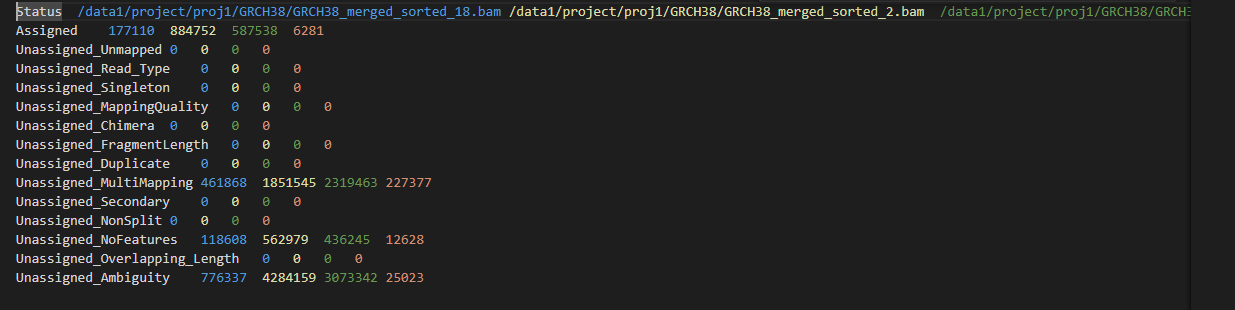

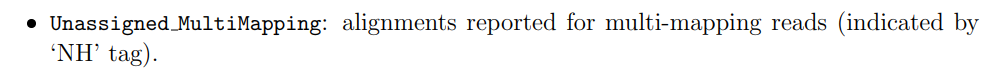

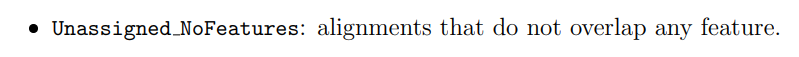

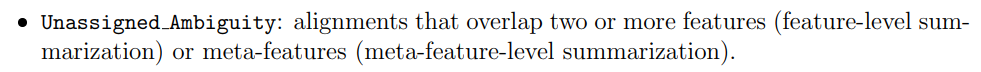

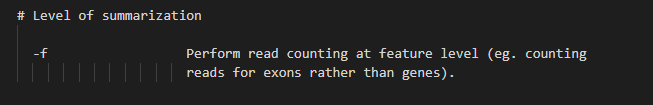

所以我们姑且认为unassigned ambiguity，即junctions，即4b问题

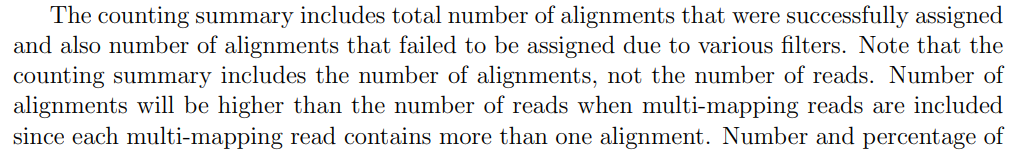

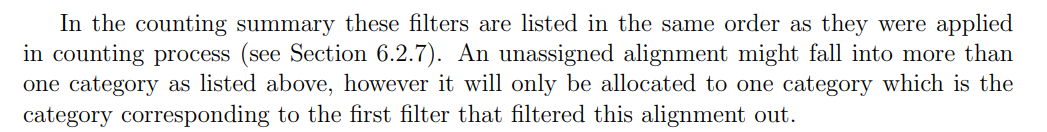

综上我们认为assigned，即为inside 1 exon，考虑到overlap多exon的已经在unassigned ambiguity，而且如果是在exon feature上分析的话，即4a

至于junction reads：

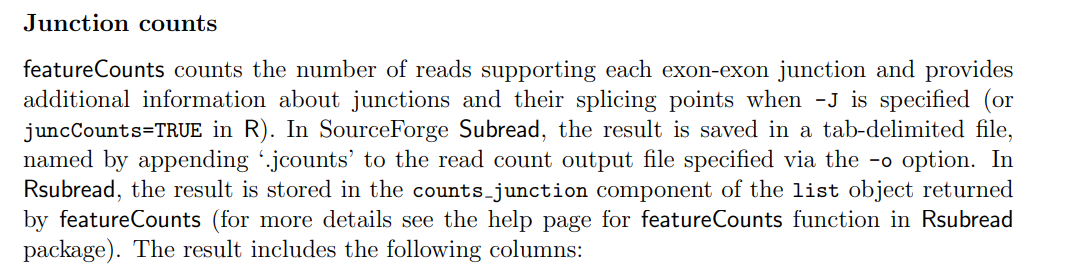

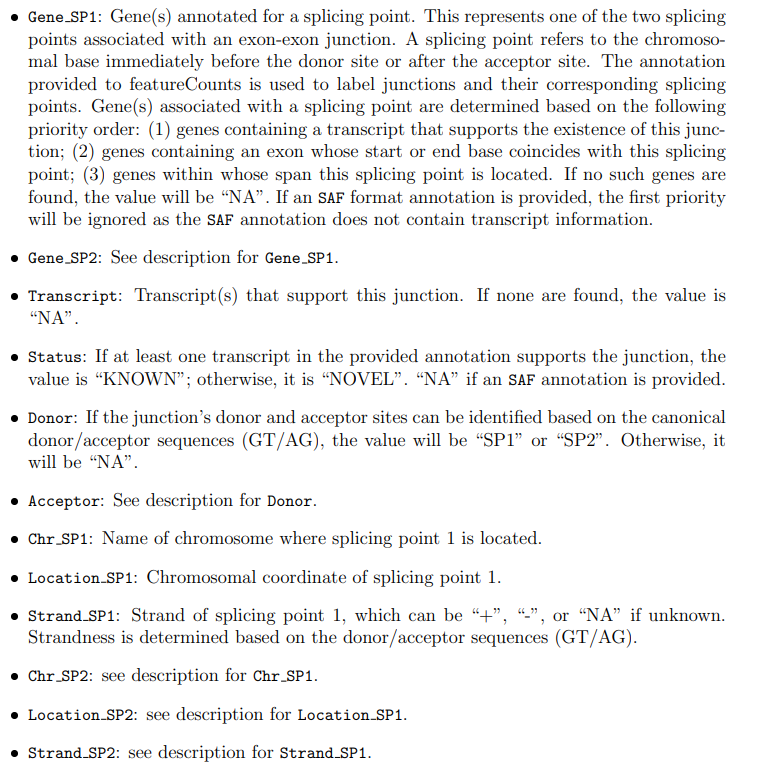

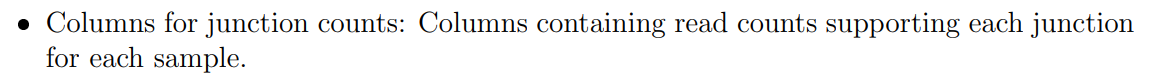

我们认为最后1列就是跨越junction的reads，而且是read counts，不是alignments，

我们姑且认为jcounts文件解决4b问题

In [3]:
import pandas as pd

# 读取文本文件
with open('/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts', 'r') as f:
    lines = f.readlines()

# 处理第一行（列名）
header = lines[0].strip().split('\t')  # 制表符分隔，根据实际情况调整分隔符
last_4_headers = header[-4:]

# 初始化求和数组
sums = [0] * 4

# 处理数据行
for line in lines[1:]:
    values = line.strip().split('\t')  # 根据实际分隔符调整
    last_4_values = values[-4:]
    
    for i, value in enumerate(last_4_values):
        try:
            sums[i] += float(value)
        except ValueError:
            # 如果不能转换为数字，跳过
            continue

# 输出结果
print("最后4列的求和结果：")
for i, (col_name, sum_value) in enumerate(zip(last_4_headers, sums)):
    print(f"{col_name}: {sum_value}")

最后4列的求和结果：
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 146640.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 841888.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 621823.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 7233.0


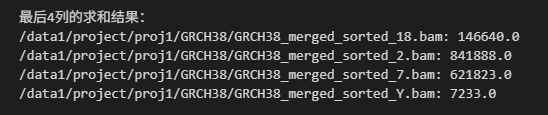

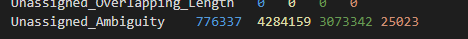

所以alignments数目一般是多于count数的

我们再来看最后4列的求和结果和，log中的总assigned

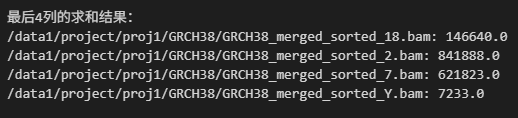

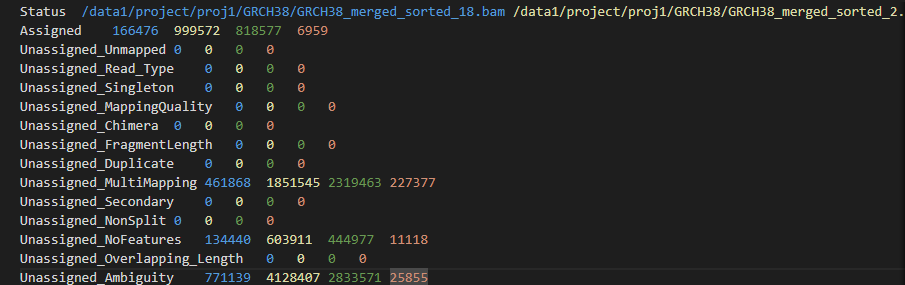

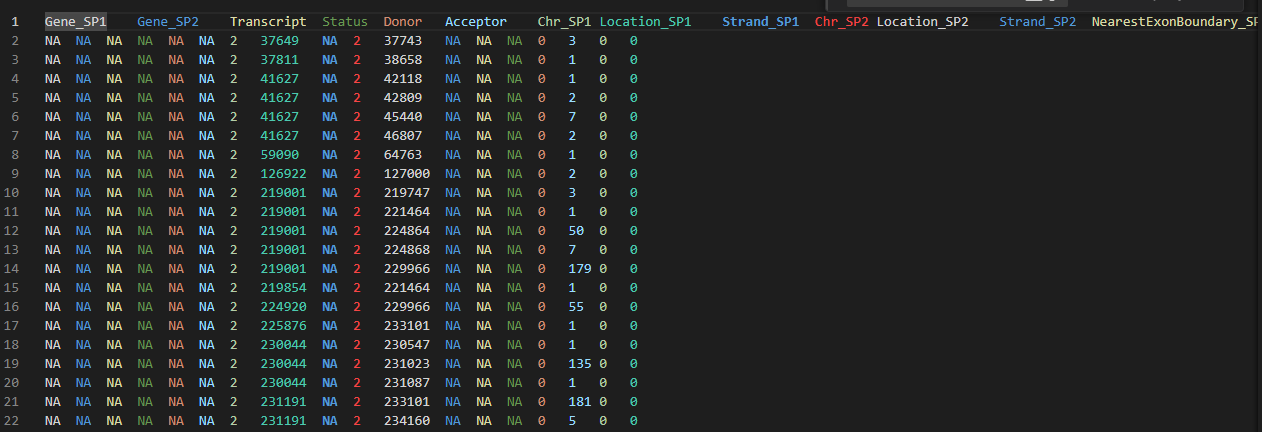

截下来解决4c问题

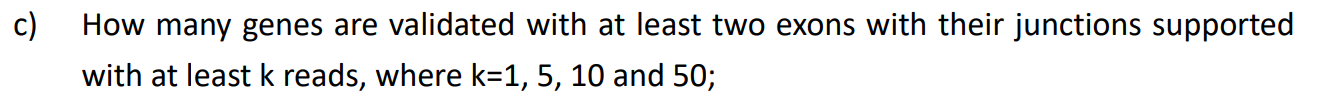

我们还是利用上面的jcounts文件，每一行都是1个exon-exon junction，然后我们只看最后4列的read counts；最重要的是我们需要看两个chr坐标，判断是什么gene

同1行的都是1个gene，

1行就是1个（2 exon），

对于同1个gene，我们看有多少行，如果每一行中这个（2 exon）的最后4列，每一列都有至少k个reads，那就是满足的



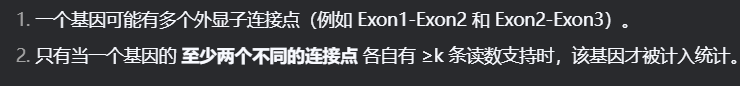

所以我们需要定位此处每一行中的loc1以及loc2到底是什么gene，

用的就是注释文件/data1/project/proj1/annotations/gencode.gtf

以及junction文件：/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts

In [ ]:
import gzip
import pandas as pd
from collections import defaultdict

# 1. 解析 GTF 文件，构建位置→基因的映射字典
def build_genome_index(gtf_path):
    """
    构建基因组位置到基因ID的映射字典
    格式: {(chrom, pos, strand): set(gene_ids)}
    """
    index = defaultdict(set)
    
    # 自动处理 gzip 压缩文件
    open_func = gzip.open if gtf_path.endswith('.gz') else open
    mode = 'rt' if gtf_path.endswith('.gz') else 'r'
    
    with open_func(gtf_path, mode) as f:
        for line in f:
            if line.startswith('#'):  # 跳过注释行
                continue
                
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
                
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            
            # 只处理 exon 和 transcript 特征
            if feature not in ['exon', 'transcript']:
                continue
                
            # 解析属性字段
            attr_dict = {}
            for attr in attributes.split(';'):
                attr = attr.strip()
                if not attr:
                    continue
                if ' ' in attr:
                    key, val = attr.split(' ', 1)
                    attr_dict[key] = val.strip('"')
            
            # 获取 gene_id
            gene_id = attr_dict.get('gene_id')
            if not gene_id:
                continue
                
            # 将位置转换为整数
            try:
                start = int(start)
                end = int(end)
            except ValueError:
                continue
                
            # 为每个位置创建索引
            for pos in range(start, end + 1):
                key = (chrom, pos, strand)
                index[key].add(gene_id)
                
    return index

# 2. 为 jcounts 文件添加基因注释
def annotate_jcounts(jcounts_path, gtf_path, output_path):
    # 构建基因组索引
    genome_index = build_genome_index(gtf_path)
    
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(jcounts_path, sep='\t', comment='#')
    
    # 准备存储结果的列表
    sp1_genes = []
    sp2_genes = []
    
    # 为每一行查找基因
    for _, row in jcounts_df.iterrows():
        # 处理 SP1
        chrom1 = f"chr{row['Chr_SP1']}" if not str(row['Chr_SP1']).startswith('chr') else row['Chr_SP1']
        pos1 = row['Location_SP1']
        strand1 = row['Strand_SP1']
        
        sp1_key = (chrom1, pos1, strand1)
        genes1 = genome_index.get(sp1_key, set())
        sp1_genes.append(";".join(genes1) if genes1 else "NA")
        
        # 处理 SP2
        chrom2 = f"chr{row['Chr_SP2']}" if not str(row['Chr_SP2']).startswith('chr') else row['Chr_SP2']
        pos2 = row['Location_SP2']
        strand2 = row['Strand_SP2']
        
        sp2_key = (chrom2, pos2, strand2)
        genes2 = genome_index.get(sp2_key, set())
        sp2_genes.append(";".join(genes2) if genes2 else "NA")
    
    # 添加新列
    jcounts_df['SP1_gene'] = sp1_genes
    jcounts_df['SP2_gene'] = sp2_genes
    
    # 保存结果
    jcounts_df.to_csv(output_path, sep='\t', index=False)
    print(f"结果已保存至: {output_path}")
    return jcounts_df

# 3. 使用
if __name__ == "__main__":
    # 输入文件路径
    jcounts_file = "/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/gencode.gtf"  
    output_file = "/data1/project/proj1/result/grch38_gencode_exon_annotated_jcounts.txt"
    
    # 执行注释
    annotated_df = annotate_jcounts(jcounts_file, gtf_file, output_file)
    

In [ ]:
import pandas as pd

# 读取 .jcounts 文件
jcounts = pd.read_csv("output.jcounts", sep="\t", comment="#")

# 定义统计函数
def count_valid_genes(jcounts_df, k):
    valid_genes = set()
    for gene in set(jcounts_df["Gene_SP1"]).union(set(jcounts_df["Gene_SP2"])):
        # 筛选该基因的连接点（支持数 ≥k）
        gene_junc = jcounts_df[
            ((jcounts_df["Gene_SP1"] == gene) | (jcounts_df["Gene_SP2"] == gene)
        ]
        gene_junc = gene_junc[gene_junc["Count"] >= k]
        # 统计唯一连接点（避免重复计数）
        unique_junc = set(zip(
            gene_junc["Chr_SP1"], gene_junc["Location_SP1"],
            gene_junc["Chr_SP2"], gene_junc["Location_SP2"]
        ))
        if len(unique_junc) >= 2:
            valid_genes.add(gene)
    return len(valid_genes)

# 计算不同 k 值的结果
for k in [1, 5, 10, 50]:
    print(f"k={k}: {count_valid_genes(jcounts, k)} genes validated")

（2）GRCh38比对结果 + Refseq注释


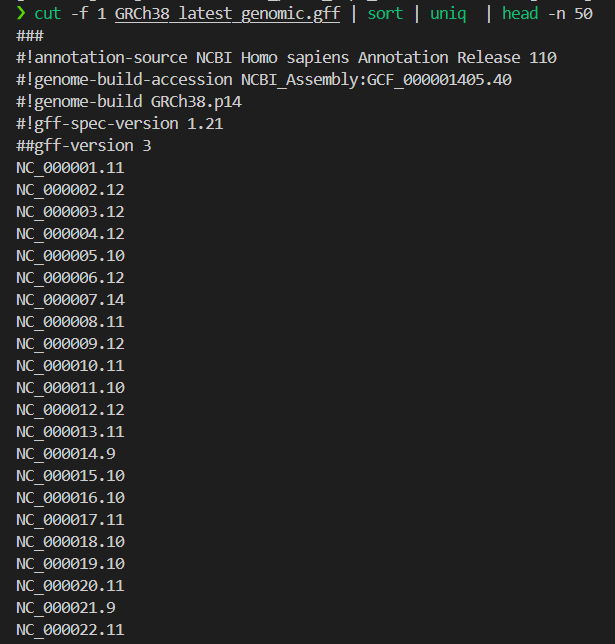

第1列是NCBI的编码NCxxxxxx，而我们的bam里是2、7、18、Y，所以需要对应-A alias2文件如下

In [1]:
!echo -e "NC_000002.12,2\nNC_000007.14,7\nNC_000018.10,18\nNC_000024.10,Y" > chr_alias2.txt

In [ ]:
#!/bin/bash

# 主要是-f选项

featureCounts -T 20 -a /data1/project/proj1/annotations/GRCh38.gtf \
    -o /data1/project/proj1/result/grch38_refseq_exon_counts.txt  \
        -t exon -f  \
        -g  transcript_id \
        -R CORE --Rpath /data1/project/proj1/result  \
        -J -A /data1/project/proj1/chr_alias2.txt /data1/project/proj1/GRCH38/*.bam

In [ ]:
nohup: ignoring input

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.1.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                                                                            ||
||                           GRCH38_merged_sorted_18.bam                      ||
||                           GRCH38_merged_sorted_2.bam                       ||
||                           GRCH38_merged_sorted_7.bam                       ||
||                           GRCH38_merged_sorted_Y.bam                       ||
||                                                                            ||
||             Output file : grch38_refseq_exon_counts.txt                    ||
||                 Summary : grch38_refseq_exon_counts.txt.summary            ||
||              Paired-end : no                                               ||
||        Count read pairs : no                                               ||
||              Annotation : GRCh38.gtf (GTF)                                 ||
||      Dir for temp files : /data1/project/proj1/result                      ||
||      Assignment details : <input_file>.featureCounts                       ||
||     Details output path : /data1/project/proj1/result                      ||
||                                                                            ||
||       Junction Counting : <output_file>.jcounts                            ||
||   Chromosome alias file : chr_alias2.txt                                   ||
||                                                                            ||
||                 Threads : 20                                               ||
||                   Level : feature level                                    ||
||      Multimapping reads : not counted                                      ||
|| Multi-overlapping reads : not counted                                      ||
||   Min overlapping bases : 1                                                ||
||                                                                            ||
\\============================================================================//

//================================= Running ==================================\\
||                                                                            ||
|| 4 chromosome name aliases are loaded.                                      ||
|| Load annotation file GRCh38.gtf ...                                        ||
||    Features : 2206931                                                      ||
||    Meta-features : 199300                                                  ||
||    Chromosomes/contigs : 531                                               ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_18.bam...                            ||
||    Single-end reads are included.                                          ||
||    Total alignments : 1533923                                              ||
||    Successfully assigned alignments : 166476 (10.9%)                       ||
||    Running time : 0.02 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_2.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 7583435                                              ||
||    Successfully assigned alignments : 999572 (13.2%)                       ||
||    Running time : 0.06 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_7.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 6416588                                              ||
||    Successfully assigned alignments : 818577 (12.8%)                       ||
||    Running time : 0.04 minutes                                             ||
||                                                                            ||
|| Process BAM file GRCH38_merged_sorted_Y.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 271309                                               ||
||    Successfully assigned alignments : 6959 (2.6%)                          ||
||    Running time : 0.00 minutes                                             ||
||                                                                            ||
|| Write the final count table.                                               ||
|| Write the junction count table.                                            ||
|| Write the read assignment summary.                                         ||
||                                                                            ||
|| Summary of counting results can be found in file "/data1/project/proj1/re  ||
|| sult/grch38_refseq_exon_counts.txt.summary"                                ||
||                                                                            ||
\\============================================================================//



In [1]:
import pandas as pd

# 读取文本文件
with open('/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts', 'r') as f:
    lines = f.readlines()

# 处理第一行（列名）
header = lines[0].strip().split('\t')  # 制表符分隔，根据实际情况调整分隔符
last_4_headers = header[-4:]

# 初始化求和数组
sums = [0] * 4

# 处理数据行
for line in lines[1:]:
    values = line.strip().split('\t')  # 根据实际分隔符调整
    last_4_values = values[-4:]
    
    for i, value in enumerate(last_4_values):
        try:
            sums[i] += float(value)
        except ValueError:
            # 如果不能转换为数字，跳过
            continue

# 输出结果
print("最后4列的求和结果：")
for i, (col_name, sum_value) in enumerate(zip(last_4_headers, sums)):
    print(f"{col_name}: {sum_value}")

最后4列的求和结果：
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 146640.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 841888.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 621823.0
/data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 7233.0


In [ ]:
import gzip
import pandas as pd
from collections import defaultdict

# 1. 解析 GTF 文件，构建位置→基因的映射字典
def build_genome_index(gtf_path):
    """
    构建基因组位置到基因ID的映射字典
    格式: {(chrom, pos, strand): set(gene_ids)}
    """
    index = defaultdict(set)
    
    # 自动处理 gzip 压缩文件
    open_func = gzip.open if gtf_path.endswith('.gz') else open
    mode = 'rt' if gtf_path.endswith('.gz') else 'r'
    
    with open_func(gtf_path, mode) as f:
        for line in f:
            if line.startswith('#'):  # 跳过注释行
                continue
                
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
                
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            
            # 只处理 exon 和 transcript 特征
            if feature not in ['exon', 'transcript']:
                continue
                
            # 解析属性字段
            attr_dict = {}
            for attr in attributes.split(';'):
                attr = attr.strip()
                if not attr:
                    continue
                if ' ' in attr:
                    key, val = attr.split(' ', 1)
                    attr_dict[key] = val.strip('"')
            
            # 获取 gene_id
            gene_id = attr_dict.get('gene_id')
            if not gene_id:
                continue
                
            # 将位置转换为整数
            try:
                start = int(start)
                end = int(end)
            except ValueError:
                continue
                
            # 为每个位置创建索引
            for pos in range(start, end + 1):
                key = (chrom, pos, strand)
                index[key].add(gene_id)
                
    return index

# 2. 为 jcounts 文件添加基因注释
def annotate_jcounts(jcounts_path, gtf_path, output_path):
    # 构建基因组索引
    genome_index = build_genome_index(gtf_path)
    
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(jcounts_path, sep='\t', comment='#')
    
    # 准备存储结果的列表
    sp1_genes = []
    sp2_genes = []
    
    # 为每一行查找基因
    for _, row in jcounts_df.iterrows():
        # 处理 SP1
        chrom1 = f"chr{row['Chr_SP1']}" if not str(row['Chr_SP1']).startswith('chr') else row['Chr_SP1']
        pos1 = row['Location_SP1']
        strand1 = row['Strand_SP1']
        
        sp1_key = (chrom1, pos1, strand1)
        genes1 = genome_index.get(sp1_key, set())
        sp1_genes.append(";".join(genes1) if genes1 else "NA")
        
        # 处理 SP2
        chrom2 = f"chr{row['Chr_SP2']}" if not str(row['Chr_SP2']).startswith('chr') else row['Chr_SP2']
        pos2 = row['Location_SP2']
        strand2 = row['Strand_SP2']
        
        sp2_key = (chrom2, pos2, strand2)
        genes2 = genome_index.get(sp2_key, set())
        sp2_genes.append(";".join(genes2) if genes2 else "NA")
    
    # 添加新列
    jcounts_df['SP1_gene'] = sp1_genes
    jcounts_df['SP2_gene'] = sp2_genes
    
    # 保存结果
    jcounts_df.to_csv(output_path, sep='\t', index=False)
    print(f"结果已保存至: {output_path}")
    return jcounts_df

# 3. 使用
if __name__ == "__main__":
    # 输入文件路径
    jcounts_file = "/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/gencode.gtf"  
    output_file = "/data1/project/proj1/result/grch38_refseq_exon_annotated_jcounts.txt"
    
    # 执行注释
    annotated_df = annotate_jcounts(jcounts_file, gtf_file, output_file)
    

In [11]:
import pandas as pd

# 读取文件
df = pd.read_csv('/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts', sep='\t')

# 获取最后4列
last_4_cols = df.iloc[:, -4:]

# 定义阈值
thresholds = [1, 5, 10, 50]

print("最后4列的列名:")
for i, col in enumerate(last_4_cols.columns):
    print(f"第{i+1}列: {col}")

print("\n各阈值下每列大于等于阈值的行数:")

# 计算每个阈值下的结果
for k in thresholds:
    print(f"\nk = {k}:")
    for i, col in enumerate(last_4_cols.columns):
        count = (last_4_cols[col] >= k).sum()
        print(f"  第{i+1}列: {count}")

print(f"\n总行数: {len(df)}")

最后4列的列名:
第1列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam
第2列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam
第3列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam
第4列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam

各阈值下每列大于等于阈值的行数:

k = 1:
  第1列: 3823
  第2列: 18208
  第3列: 13377
  第4列: 369

k = 5:
  第1列: 1754
  第2列: 9134
  第3列: 6432
  第4列: 94

k = 10:
  第1列: 1277
  第2列: 6899
  第3列: 4769
  第4列: 64

k = 50:
  第1列: 420
  第2列: 2767
  第3列: 1822
  第4列: 15

总行数: 35777


/tmp/ipykernel_3987836/3194953821.py:4: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts', sep='\t')


In [10]:
import pandas as pd

# 读取文件
df = pd.read_csv('/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts', sep='\t')

# 获取最后4列
last_4_cols = df.iloc[:, -4:]

# 定义阈值
thresholds = [1, 5, 10, 50]

print("最后4列的列名:")
for i, col in enumerate(last_4_cols.columns):
    print(f"第{i+1}列: {col}")

print("\n各阈值下每列大于等于阈值的行数:")

# 计算每个阈值下的结果
for k in thresholds:
    print(f"\nk = {k}:")
    for i, col in enumerate(last_4_cols.columns):
        count = (last_4_cols[col] >= k).sum()
        print(f"  第{i+1}列: {count}")

print(f"\n总行数: {len(df)}")

最后4列的列名:
第1列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam
第2列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam
第3列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam
第4列: /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam

各阈值下每列大于等于阈值的行数:

k = 1:
  第1列: 3823
  第2列: 18208
  第3列: 13377
  第4列: 369

k = 5:
  第1列: 1754
  第2列: 9134
  第3列: 6432
  第4列: 94

k = 10:
  第1列: 1277
  第2列: 6899
  第3列: 4769
  第4列: 64

k = 50:
  第1列: 420
  第2列: 2767
  第3列: 1822
  第4列: 15

总行数: 35777


/tmp/ipykernel_3987836/928315238.py:4: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts', sep='\t')


（3）T2T比对结果 + T2T注释

T2T比对的结果：/data1/project/proj1/output/aligned/T2T/*_sorted_2718Y.bam

T2T注释是：/data1/project/proj1/annotations/Homo_sapiens-GCA_009914755.4-2022_07-genes.gff3，或者是gffread转化之后的T2T.gtf

cut -f 3 Homo_sapiens-GCA_009914755.4-2022_07-genes.gff3 | sort | uniq，发现有exon就够了

该注释中第3列的feature type有gene、exon、transcript，最后1列的attribute我们可以任选，这里选transcript_id

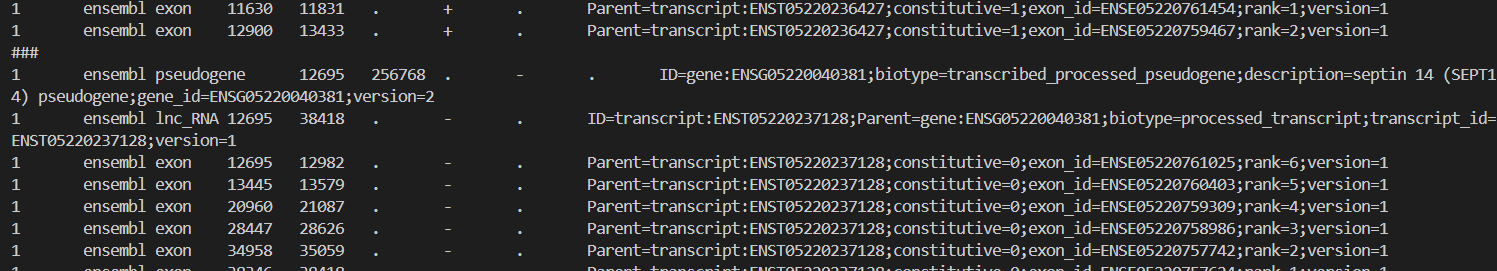

第1列是ensembl的编码，而我们的bam里是chr2、7、18、Y，还是要转换

In [2]:
!echo -2 "2,chr2\n7,chr7\n18,chr18\nY,chrY" > chr_alias3.txt

In [ ]:
#!/bin/bash

# 主要是-f选项

featureCounts -T 20 -a /data1/project/proj1/annotations/T2T.gtf \
    -o /data1/project/proj1/result/T2T_T2T_exon_counts.txt  \
        -t exon -f  \
        -g  gene_id \
        -R CORE --Rpath /data1/project/proj1/result  \
        -J -A /data1/project/proj1/chr_alias3.txt /data1/project/proj1/T2T/*.bam


In [ ]:
nohup: ignoring input

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.1.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                                                                            ||
||                           T2T_merged_sorted_chr18.bam                      ||
||                           T2T_merged_sorted_chr2.bam                       ||
||                           T2T_merged_sorted_chr7.bam                       ||
||                           T2T_merged_sorted_chrY.bam                       ||
||                                                                            ||
||             Output file : T2T_T2T_exon_counts.txt                          ||
||                 Summary : T2T_T2T_exon_counts.txt.summary                  ||
||              Paired-end : no                                               ||
||        Count read pairs : no                                               ||
||              Annotation : T2T.gtf (GTF)                                    ||
||      Dir for temp files : /data1/project/proj1/result                      ||
||      Assignment details : <input_file>.featureCounts                       ||
||     Details output path : /data1/project/proj1/result                      ||
||                                                                            ||
||       Junction Counting : <output_file>.jcounts                            ||
||   Chromosome alias file : chr_alias3.txt                                   ||
||                                                                            ||
||                 Threads : 20                                               ||
||                   Level : feature level                                    ||
||      Multimapping reads : not counted                                      ||
|| Multi-overlapping reads : not counted                                      ||
||   Min overlapping bases : 1                                                ||
||                                                                            ||
\\============================================================================//

//================================= Running ==================================\\
||                                                                            ||
|| 1 chromosome name aliases are loaded.                                      ||
|| Load annotation file T2T.gtf ...                                           ||
||    Features : 1483825                                                      ||
||    Meta-features : 61988                                                   ||
||    Chromosomes/contigs : 24                                                ||
||                                                                            ||
|| Process BAM file T2T_merged_sorted_chr18.bam...                            ||
||    Single-end reads are included.                                          ||
||    Total alignments : 1540581                                              ||
||    Successfully assigned alignments : 181230 (11.8%)                       ||
||    Running time : 0.02 minutes                                             ||
||                                                                            ||
|| Process BAM file T2T_merged_sorted_chr2.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 7665238                                              ||
||    Successfully assigned alignments : 896117 (11.7%)                       ||
||    Running time : 0.06 minutes                                             ||
||                                                                            ||
|| Process BAM file T2T_merged_sorted_chr7.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 6445033                                              ||
||    Successfully assigned alignments : 586339 (9.1%)                        ||
||    Running time : 0.04 minutes                                             ||
||                                                                            ||
|| Process BAM file T2T_merged_sorted_chrY.bam...                             ||
||    Single-end reads are included.                                          ||
||    Total alignments : 381685                                               ||
||    Successfully assigned alignments : 6396 (1.7%)                          ||
||    Running time : 0.00 minutes                                             ||
||                                                                            ||
|| Write the final count table.                                               ||
|| Write the junction count table.                                            ||
|| Write the read assignment summary.                                         ||
||                                                                            ||
|| Summary of counting results can be found in file "/data1/project/proj1/re  ||
|| sult/T2T_T2T_exon_counts.txt.summary"                                      ||
||                                                                            ||
\\============================================================================//



In [2]:
import pandas as pd

# 读取文本文件
with open('/data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts', 'r') as f:
    lines = f.readlines()

# 处理第一行（列名）
header = lines[0].strip().split('\t')  # 制表符分隔，根据实际情况调整分隔符
last_4_headers = header[-4:]

# 初始化求和数组
sums = [0] * 4

# 处理数据行
for line in lines[1:]:
    values = line.strip().split('\t')  # 根据实际分隔符调整
    last_4_values = values[-4:]
    
    for i, value in enumerate(last_4_values):
        try:
            sums[i] += float(value)
        except ValueError:
            # 如果不能转换为数字，跳过
            continue

# 输出结果
print("最后4列的求和结果：")
for i, (col_name, sum_value) in enumerate(zip(last_4_headers, sums)):
    print(f"{col_name}: {sum_value}")

最后4列的求和结果：
/data1/project/proj1/T2T/T2T_merged_sorted_chr18.bam: 143594.0
/data1/project/proj1/T2T/T2T_merged_sorted_chr2.bam: 842432.0
/data1/project/proj1/T2T/T2T_merged_sorted_chr7.bam: 620450.0
/data1/project/proj1/T2T/T2T_merged_sorted_chrY.bam: 18755.0


In [ ]:
import gzip
import pandas as pd
from collections import defaultdict

# 1. 解析 GTF 文件，构建位置→基因的映射字典
def build_genome_index(gtf_path):
    """
    构建基因组位置到基因ID的映射字典
    格式: {(chrom, pos, strand): set(gene_ids)}
    """
    index = defaultdict(set)
    
    # 自动处理 gzip 压缩文件
    open_func = gzip.open if gtf_path.endswith('.gz') else open
    mode = 'rt' if gtf_path.endswith('.gz') else 'r'
    
    with open_func(gtf_path, mode) as f:
        for line in f:
            if line.startswith('#'):  # 跳过注释行
                continue
                
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
                
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            
            # 只处理 exon 和 transcript 特征
            if feature not in ['exon', 'transcript']:
                continue
                
            # 解析属性字段
            attr_dict = {}
            for attr in attributes.split(';'):
                attr = attr.strip()
                if not attr:
                    continue
                if ' ' in attr:
                    key, val = attr.split(' ', 1)
                    attr_dict[key] = val.strip('"')
            
            # 获取 gene_id
            gene_id = attr_dict.get('gene_id')
            if not gene_id:
                continue
                
            # 将位置转换为整数
            try:
                start = int(start)
                end = int(end)
            except ValueError:
                continue
                
            # 为每个位置创建索引
            for pos in range(start, end + 1):
                key = (chrom, pos, strand)
                index[key].add(gene_id)
                
    return index

# 2. 为 jcounts 文件添加基因注释
def annotate_jcounts(jcounts_path, gtf_path, output_path):
    # 构建基因组索引
    genome_index = build_genome_index(gtf_path)
    
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(jcounts_path, sep='\t', comment='#')
    
    # 准备存储结果的列表
    sp1_genes = []
    sp2_genes = []
    
    # 为每一行查找基因
    for _, row in jcounts_df.iterrows():
        # 处理 SP1
        chrom1 = f"chr{row['Chr_SP1']}" if not str(row['Chr_SP1']).startswith('chr') else row['Chr_SP1']
        pos1 = row['Location_SP1']
        strand1 = row['Strand_SP1']
        
        sp1_key = (chrom1, pos1, strand1)
        genes1 = genome_index.get(sp1_key, set())
        sp1_genes.append(";".join(genes1) if genes1 else "NA")
        
        # 处理 SP2
        chrom2 = f"chr{row['Chr_SP2']}" if not str(row['Chr_SP2']).startswith('chr') else row['Chr_SP2']
        pos2 = row['Location_SP2']
        strand2 = row['Strand_SP2']
        
        sp2_key = (chrom2, pos2, strand2)
        genes2 = genome_index.get(sp2_key, set())
        sp2_genes.append(";".join(genes2) if genes2 else "NA")
    
    # 添加新列
    jcounts_df['SP1_gene'] = sp1_genes
    jcounts_df['SP2_gene'] = sp2_genes
    
    # 保存结果
    jcounts_df.to_csv(output_path, sep='\t', index=False)
    print(f"结果已保存至: {output_path}")
    return jcounts_df

# 3. 使用
if __name__ == "__main__":
    # 输入文件路径
    jcounts_file = "/data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/T2T.gtf"  
    output_file = "/data1/project/proj1/result/T2T_T2T_exon_annotated_jcounts.txt"
    
    # 执行注释
    annotated_df = annotate_jcounts(jcounts_file, gtf_file, output_file)
    

统计4C

grch38+gencode

In [ ]:
import pandas as pd
import re
from collections import defaultdict

def parse_gtf_attributes(attr_string):
    """解析GTF文件的属性字段"""
    attributes = {}
    # 匹配所有的 key "value" 对
    pattern = r'(\w+)\s+"([^"]+)"'
    matches = re.findall(pattern, attr_string)
    for key, value in matches:
        attributes[key] = value
    return attributes

def load_gtf_genes(gtf_file):
    """加载GTF文件并构建基因区间索引"""
    gene_intervals = defaultdict(list)  # {chromosome: [(start, end, gene_id, gene_name), ...]}
    
    print("正在读取GTF文件...")
    with open(gtf_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if line_num % 100000 == 0:
                print(f"已处理 {line_num} 行")
            
            if line.startswith('#'):
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
            
            chromosome = parts[0]
            feature_type = parts[2]
            start = int(parts[3])
            end = int(parts[4])
            attributes_str = parts[8]
            
            # 只处理gene或transcript记录
            if feature_type in ['gene', 'transcript']:
                attributes = parse_gtf_attributes(attributes_str)
                gene_id = attributes.get('gene_id', 'Unknown')
                gene_name = attributes.get('gene_name', 'Unknown')
                
                gene_intervals[chromosome].append((start, end, gene_id, gene_name))
    
    # 对每个染色体的区间进行排序，便于查找
    for chrom in gene_intervals:
        gene_intervals[chrom].sort(key=lambda x: x[0])
    
    print(f"GTF文件读取完成，共处理了 {sum(len(intervals) for intervals in gene_intervals.values())} 个基因/转录本记录")
    return gene_intervals

def find_gene_at_position(gene_intervals, chromosome, position):
    """在指定染色体位置查找基因"""
    if chromosome not in gene_intervals:
        return "Unknown", "Unknown"
    
    # 查找包含该位置的所有基因
    matching_genes = []
    for start, end, gene_id, gene_name in gene_intervals[chromosome]:
        if start <= position <= end:
            matching_genes.append((gene_id, gene_name))
    
    if matching_genes:
        # 如果有多个匹配的基因，返回第一个
        return matching_genes[0]
    else:
        return "Intergenic", "Intergenic"

def process_jcounts_file(jcounts_file, gtf_file, output_file):
    """处理jcounts文件，添加基因注释"""
    
    # 加载GTF文件
    gene_intervals = load_gtf_genes(gtf_file)
    
    # 读取jcounts文件
    print("正在读取jcounts文件...")
    with open(jcounts_file, 'r') as f:
        lines = f.readlines()
    
    # 处理每一行
    results = []
    print("正在处理jcounts文件的每一行...")
    
    for i, line in enumerate(lines):
        if i % 1000 == 0:
            print(f"已处理 {i} 行")
        
        parts = line.strip().split('\t')
        
        # Chr_SP1在第7列(索引6)，Location_SP1在第8列(索引7)
        # Chr_SP2和Location_SP2的位置需要根据实际文件格式确定
        if len(parts) >= 12:  # 确保有足够的列
            try:
                # 提取位置信息
                chr_sp1 = parts[6] if parts[6] != 'NA' else None
                loc_sp1 = int(parts[7]) if parts[7] != 'NA' else None
                chr_sp2 = parts[9] if parts[9] != 'NA' else None  # 假设Chr_SP2在第10列
                loc_sp2 = int(parts[10]) if parts[10] != 'NA' else None  # 假设Location_SP2在第11列
                
                # 查找对应的基因
                if chr_sp1 and loc_sp1:
                    # 确保染色体格式一致（添加chr前缀如果需要）
                    if not chr_sp1.startswith('chr'):
                        chr_sp1 = 'chr' + str(chr_sp1)
                    gene_id1, gene_name1 = find_gene_at_position(gene_intervals, chr_sp1, loc_sp1)
                else:
                    gene_id1, gene_name1 = "NA", "NA"
                
                if chr_sp2 and loc_sp2:
                    if not chr_sp2.startswith('chr'):
                        chr_sp2 = 'chr' + str(chr_sp2)
                    gene_id2, gene_name2 = find_gene_at_position(gene_intervals, chr_sp2, loc_sp2)
                else:
                    gene_id2, gene_name2 = "NA", "NA"
                
            except (ValueError, IndexError):
                gene_id1, gene_name1 = "Error", "Error"
                gene_id2, gene_name2 = "Error", "Error"
        else:
            gene_id1, gene_name1 = "InsufficientColumns", "InsufficientColumns"
            gene_id2, gene_name2 = "InsufficientColumns", "InsufficientColumns"
        
        # 添加基因信息到原始行
        new_line = line.strip() + '\t' + gene_id1 + '\t' + gene_name1 + '\t' + gene_id2 + '\t' + gene_name2 + '\n'
        results.append(new_line)
    
    # 写入结果文件
    print("正在写入结果文件...")
    with open(output_file, 'w') as f:
        f.writelines(results)
    
    print(f"处理完成！结果已保存到 {output_file}")

# 使用示例
if __name__ == "__main__":
    jcounts_file = "/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/gencode.gtf"  
    output_file = "/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts.annotated"
    
    process_jcounts_file(jcounts_file, gtf_file, output_file)

正在读取GTF文件...
已处理 100000 行
已处理 200000 行
已处理 300000 行
已处理 400000 行
已处理 500000 行
已处理 600000 行
已处理 700000 行
已处理 800000 行
已处理 900000 行
已处理 1000000 行
已处理 1100000 行
已处理 1200000 行
已处理 1300000 行
已处理 1400000 行
已处理 1500000 行
已处理 1600000 行
已处理 1700000 行
已处理 1800000 行
已处理 1900000 行
已处理 2000000 行
已处理 2100000 行
已处理 2200000 行
已处理 2300000 行
已处理 2400000 行
已处理 2500000 行
已处理 2600000 行
已处理 2700000 行
已处理 2800000 行
GTF文件读取完成，共处理了 267749 个基因/转录本记录
正在读取jcounts文件...
正在处理jcounts文件的每一行...
已处理 0 行
已处理 1000 行
已处理 2000 行
已处理 3000 行
已处理 4000 行
已处理 5000 行
已处理 6000 行
已处理 7000 行
已处理 8000 行
已处理 9000 行
已处理 10000 行
已处理 11000 行
已处理 12000 行
已处理 13000 行
已处理 14000 行
已处理 15000 行
已处理 16000 行
已处理 17000 行
已处理 18000 行
已处理 19000 行
已处理 20000 行
已处理 21000 行
已处理 22000 行
已处理 23000 行
已处理 24000 行
已处理 25000 行
已处理 26000 行
已处理 27000 行
已处理 28000 行
已处理 29000 行
已处理 30000 行
已处理 31000 行
已处理 32000 行
已处理 33000 行
已处理 34000 行
已处理 35000 行
正在写入结果文件...
处理完成！结果已保存到 /data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts.annotated


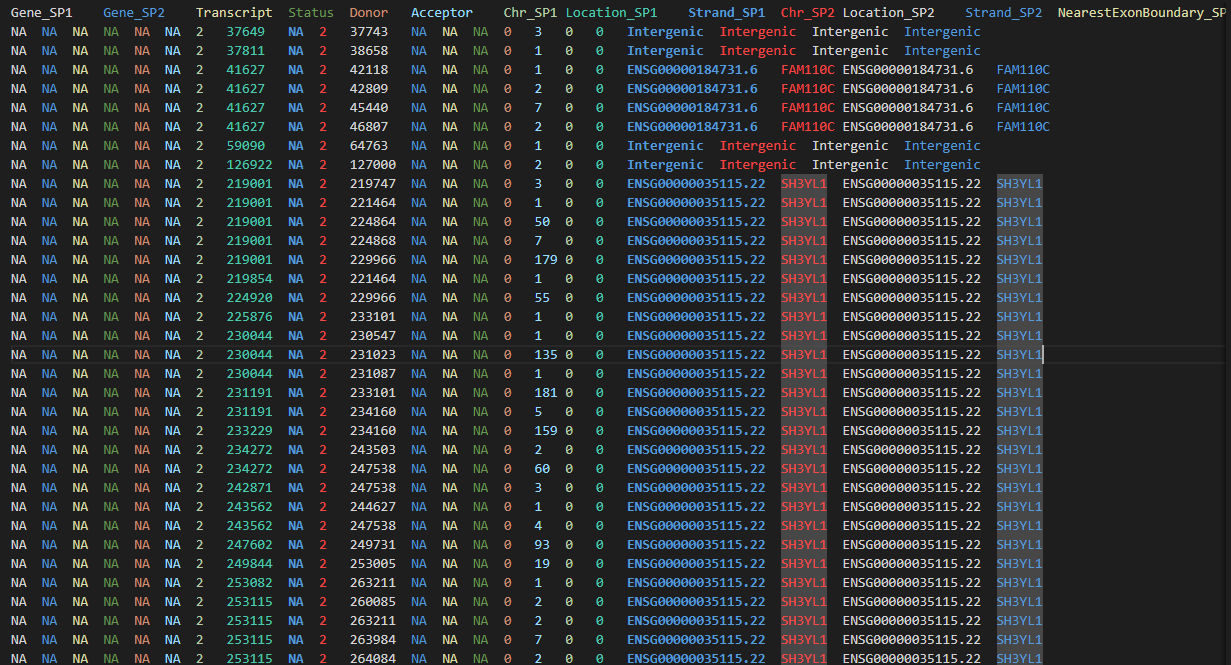

我们只看最后2行的gene

In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_jcounts_file(file_path, k_values=[1, 5, 10, 50]):
    """
    处理 jcounts 文件，统计满足条件的基因数量
    :param file_path: jcounts 文件路径
    :param k_values: 阈值列表，默认为 [1, 5, 10, 50]
    :return: 统计结果字典
    """
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(file_path, sep='\t',header=0)
    
    # 获取统计列索引（15-18列，索引为14-17）
    stat_columns = jcounts_df.columns[14:18]
    
    # 获取基因ID列索引（倒数第2列和倒数第4列）
    gene_id_col1 = jcounts_df.columns[-2]  # 倒数第2列
    gene_id_col2 = jcounts_df.columns[-4]  # 倒数第4列
    
    # 初始化结果字典
    results = {}
    
    # 对每个阈值k进行处理
    for k in k_values:
        k_results = {}
        
        # 对每个统计列进行处理
        for col in stat_columns:
            # 创建基因计数器
            gene_counter = defaultdict(list)
            
            # 遍历每一行
            for _, row in jcounts_df.iterrows():
                # 获取当前统计列的值
                count_value = row[col]
                
                # 获取基因ID
                gene_id1 = row[gene_id_col1]
                gene_id2 = row[gene_id_col2]
                
                # 处理第一个基因ID
                if pd.notna(gene_id1) and gene_id1 != "NA" and gene_id1 != "Intergenic":
                    gene_counter[gene_id1].append(count_value)
                
                # 处理第二个基因ID
                if pd.notna(gene_id2) and gene_id2 != "NA" and gene_id2 != "Intergenic" and gene_id2 != gene_id1:
                    gene_counter[gene_id2].append(count_value)
            
            # 统计满足条件的基因数量
            valid_genes = 0
            for gene_id, counts in gene_counter.items():
                # 检查是否满足两个条件：
                # 1. 出现行数 >= 2
                # 2. 只要有2行出现的行都 >= k
                if len(counts) >= 2 and sum(1 for c in counts if c >= k) >= 2:
                    valid_genes += 1
            
            k_results[col] = valid_genes
        
        results[k] = k_results
    
    return results

def main():
    # 文件路径
    jcounts_file = "/data1/project/proj1/result/grch38_gencode_exon_counts.txt.jcounts.annotated"
    
    # 处理文件
    results = process_jcounts_file(jcounts_file)
    
    # 打印结果
    for k, k_results in results.items():
        print(f"\n阈值 k = {k}:")
        for col, count in k_results.items():
            print(f"  列 {col}: {count} 个基因满足条件")

if __name__ == "__main__":
    main()

/tmp/ipykernel_3987836/2183017040.py:13: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  jcounts_df = pd.read_csv(file_path, sep='\t',header=0)



阈值 k = 1:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 275 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 1275 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 922 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 36 个基因满足条件

阈值 k = 5:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 184 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 885 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 670 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 17 个基因满足条件

阈值 k = 10:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 157 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 755 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 566 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 12 个基因满足条件

阈值 k = 50:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 78 个基因满足条件
  列 /data1/projec

grch38+refseq

In [17]:
import pandas as pd
import re
from collections import defaultdict

def load_chromosome_mapping(mapping_file):
    """加载染色体映射文件"""
    chr_mapping = {}
    try:
        with open(mapping_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line and ',' in line:
                    gtf_chr, junction_chr = line.split(',')
                    chr_mapping[gtf_chr.strip()] = junction_chr.strip()
        print(f"加载了 {len(chr_mapping)} 个染色体映射")
        return chr_mapping
    except FileNotFoundError:
        print(f"映射文件 {mapping_file} 未找到，使用默认映射")
        return {}

def parse_gtf_attributes(attr_string):
    """解析GTF文件的属性字段"""
    attributes = {}
    # 匹配所有的 key "value" 对
    pattern = r'(\w+)\s+"([^"]+)"'
    matches = re.findall(pattern, attr_string)
    for key, value in matches:
        attributes[key] = value
    return attributes

def load_gtf_genes(gtf_file, chr_mapping=None):
    """加载GTF文件并构建基因区间索引"""
    gene_intervals = defaultdict(list)  # {chromosome: [(start, end, gene_id, gene_name), ...]}
    
    print("正在读取GTF文件...")
    with open(gtf_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if line_num % 100000 == 0:
                print(f"已处理 {line_num} 行")
            
            if line.startswith('#'):
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
            
            chromosome = parts[0]
            feature_type = parts[2]
            start = int(parts[3])
            end = int(parts[4])
            attributes_str = parts[8]
            
            # 只处理gene或transcript记录
            if feature_type in ['gene', 'transcript']:
                attributes = parse_gtf_attributes(attributes_str)
                gene_id = attributes.get('gene_id', 'Unknown')
                gene_name = attributes.get('gene_name', 'Unknown')
                
                # 应用染色体映射
                mapped_chr = chromosome
                if chr_mapping and chromosome in chr_mapping:
                    mapped_chr = chr_mapping[chromosome]
                
                gene_intervals[mapped_chr].append((start, end, gene_id, gene_name))
    
    # 对每个染色体的区间进行排序，便于查找
    for chrom in gene_intervals:
        gene_intervals[chrom].sort(key=lambda x: x[0])
    
    print(f"GTF文件读取完成，共处理了 {sum(len(intervals) for intervals in gene_intervals.values())} 个基因/转录本记录")
    return gene_intervals

def find_gene_at_position(gene_intervals, chromosome, position):
    """在指定染色体位置查找基因"""
    if chromosome not in gene_intervals:
        return "Unknown", "Unknown"
    
    # 查找包含该位置的所有基因
    matching_genes = []
    for start, end, gene_id, gene_name in gene_intervals[chromosome]:
        if start <= position <= end:
            matching_genes.append((gene_id, gene_name))
    
    if matching_genes:
        # 如果有多个匹配的基因，返回第一个
        return matching_genes[0]
    else:
        return "Intergenic", "Intergenic"

def process_jcounts_file(jcounts_file, gtf_file, output_file, chr_mapping_file=None):
    """处理jcounts文件，添加基因注释"""
    
    # 加载染色体映射
    chr_mapping = load_chromosome_mapping(chr_mapping_file) if chr_mapping_file else {}
    
    # 加载GTF文件
    gene_intervals = load_gtf_genes(gtf_file, chr_mapping)
    
    # 读取jcounts文件
    print("正在读取jcounts文件...")
    with open(jcounts_file, 'r') as f:
        lines = f.readlines()
    
    # 处理每一行
    results = []
    print("正在处理jcounts文件的每一行...")
    
    for i, line in enumerate(lines):
        if i % 1000 == 0:
            print(f"已处理 {i} 行")
        
        parts = line.strip().split('\t')
        
        # Chr_SP1在第7列(索引6)，Location_SP1在第8列(索引7)
        # Chr_SP2和Location_SP2的位置需要根据实际文件格式确定
        if len(parts) >= 12:  # 确保有足够的列
            try:
                # 提取位置信息
                chr_sp1 = parts[6] if parts[6] != 'NA' else None
                loc_sp1 = int(parts[7]) if parts[7] != 'NA' else None
                chr_sp2 = parts[9] if parts[9] != 'NA' else None  # Chr_SP2在第10列
                loc_sp2 = int(parts[10]) if parts[10] != 'NA' else None  # Location_SP2在第11列
                
                # 查找对应的基因（直接使用junction文件中的染色体编号，因为GTF已经映射过了）
                if chr_sp1 and loc_sp1:
                    gene_id1, gene_name1 = find_gene_at_position(gene_intervals, chr_sp1, loc_sp1)
                else:
                    gene_id1, gene_name1 = "NA", "NA"
                
                if chr_sp2 and loc_sp2:
                    gene_id2, gene_name2 = find_gene_at_position(gene_intervals, chr_sp2, loc_sp2)
                else:
                    gene_id2, gene_name2 = "NA", "NA"
                
            except (ValueError, IndexError):
                gene_id1, gene_name1 = "Error", "Error"
                gene_id2, gene_name2 = "Error", "Error"
        else:
            gene_id1, gene_name1 = "InsufficientColumns", "InsufficientColumns"
            gene_id2, gene_name2 = "InsufficientColumns", "InsufficientColumns"
        
        # 添加基因信息到原始行
        new_line = line.strip() + '\t' + gene_id1 + '\t' + gene_name1 + '\t' + gene_id2 + '\t' + gene_name2 + '\n'
        results.append(new_line)
    
    # 写入结果文件
    print("正在写入结果文件...")
    with open(output_file, 'w') as f:
        f.writelines(results)
    
    print(f"处理完成！结果已保存到 {output_file}")

# 使用示例
if __name__ == "__main__":
    # 创建染色体映射文件
    mapping_content = """NC_000002.12,2
NC_000007.14,7
NC_000018.10,18
NC_000024.10,Y"""
    
    with open("/data1/project/proj1/chr_mapping_refseq.txt", 'w') as f:
        f.write(mapping_content)
    
    # GRCh38 + RefSeq 注释
    jcounts_file = "/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/GRCh38.gtf"  
    output_file = "/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts.annotated"
    chr_mapping_file = "/data1/project/proj1/chr_mapping_refseq.txt"
    
    process_jcounts_file(jcounts_file, gtf_file, output_file, chr_mapping_file)

加载了 4 个染色体映射
正在读取GTF文件...
已处理 100000 行
已处理 200000 行
已处理 300000 行
已处理 400000 行
已处理 500000 行
已处理 600000 行
已处理 700000 行
已处理 800000 行
已处理 900000 行
已处理 1000000 行
已处理 1100000 行
已处理 1200000 行
已处理 1300000 行
已处理 1400000 行
已处理 1500000 行
已处理 1600000 行
已处理 1700000 行
已处理 1800000 行
已处理 1900000 行
已处理 2000000 行
已处理 2100000 行
已处理 2200000 行
已处理 2300000 行
已处理 2400000 行
已处理 2500000 行
已处理 2600000 行
已处理 2700000 行
已处理 2800000 行
已处理 2900000 行
已处理 3000000 行
已处理 3100000 行
已处理 3200000 行
已处理 3300000 行
已处理 3400000 行
已处理 3500000 行
已处理 3600000 行
已处理 3700000 行
已处理 3800000 行
已处理 3900000 行
已处理 4000000 行
已处理 4100000 行
GTF文件读取完成，共处理了 199300 个基因/转录本记录
正在读取jcounts文件...
正在处理jcounts文件的每一行...
已处理 0 行
已处理 1000 行
已处理 2000 行
已处理 3000 行
已处理 4000 行
已处理 5000 行
已处理 6000 行
已处理 7000 行
已处理 8000 行
已处理 9000 行
已处理 10000 行
已处理 11000 行
已处理 12000 行
已处理 13000 行
已处理 14000 行
已处理 15000 行
已处理 16000 行
已处理 17000 行
已处理 18000 行
已处理 19000 行
已处理 20000 行
已处理 21000 行
已处理 22000 行
已处理 23000 行
已处理 24000 行
已处理 25000 行
已处理 26000 行
已处理 27000 行
已处理 28000 行
已处理 

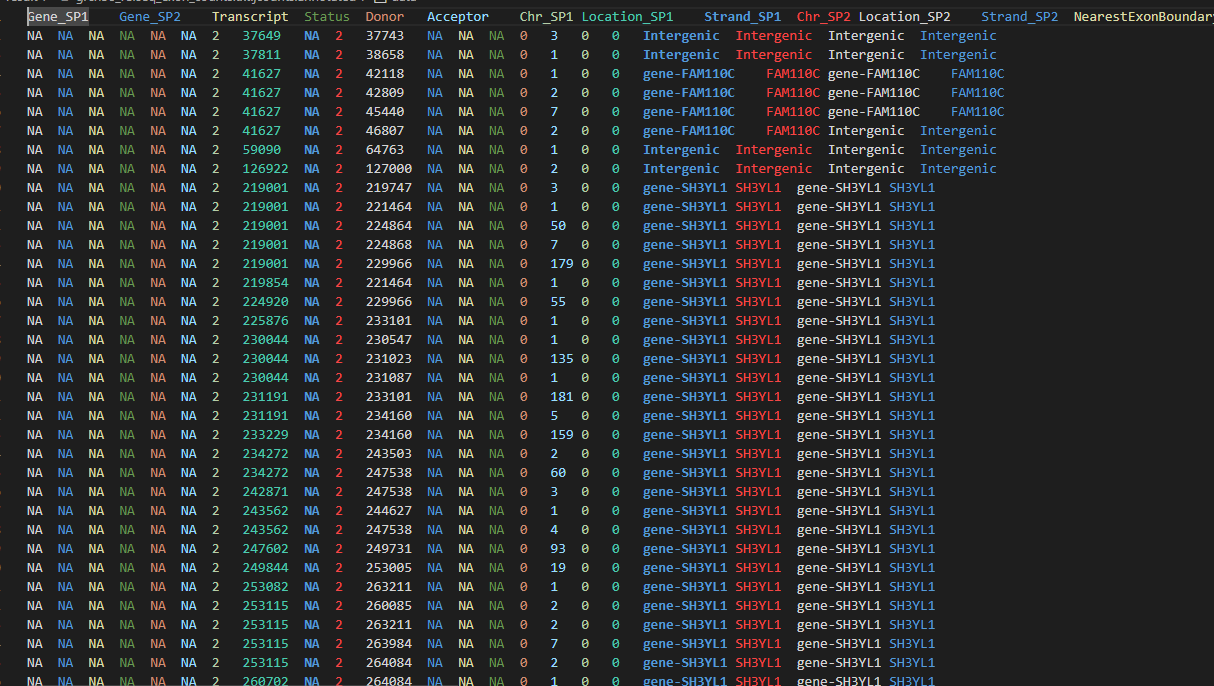

In [20]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_jcounts_file(file_path, k_values=[1, 5, 10, 50]):
    """
    处理 jcounts 文件，统计满足条件的基因数量
    :param file_path: jcounts 文件路径
    :param k_values: 阈值列表，默认为 [1, 5, 10, 50]
    :return: 统计结果字典
    """
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(file_path, sep='\t',header=0)
    
    # 获取统计列索引（15-18列，索引为14-17）
    stat_columns = jcounts_df.columns[14:18]
    
    # 获取基因ID列索引（倒数第2列和倒数第4列）
    gene_id_col1 = jcounts_df.columns[-2]  # 倒数第2列
    gene_id_col2 = jcounts_df.columns[-4]  # 倒数第4列
    
    # 初始化结果字典
    results = {}
    
    # 对每个阈值k进行处理
    for k in k_values:
        k_results = {}
        
        # 对每个统计列进行处理
        for col in stat_columns:
            # 创建基因计数器
            gene_counter = defaultdict(list)
            
            # 遍历每一行
            for _, row in jcounts_df.iterrows():
                # 获取当前统计列的值
                count_value = row[col]
                
                # 获取基因ID
                gene_id1 = row[gene_id_col1]
                gene_id2 = row[gene_id_col2]
                
                # 处理第一个基因ID
                if pd.notna(gene_id1) and gene_id1 != "NA" and gene_id1 != "Intergenic":
                    gene_counter[gene_id1].append(count_value)
                
                # 处理第二个基因ID
                if pd.notna(gene_id2) and gene_id2 != "NA" and gene_id2 != "Intergenic" and gene_id2 != gene_id1:
                    gene_counter[gene_id2].append(count_value)
            
            # 统计满足条件的基因数量
            valid_genes = 0
            for gene_id, counts in gene_counter.items():
                # 检查是否满足两个条件：
                # 1. 出现行数 >= 2
                # 2. 只要有2行出现的行都 >= k
                if len(counts) >= 2 and sum(1 for c in counts if c >= k) >= 2:
                    valid_genes += 1
            
            k_results[col] = valid_genes
        
        results[k] = k_results
    
    return results

def main():
    # 文件路径
    jcounts_file = "/data1/project/proj1/result/grch38_refseq_exon_counts.txt.jcounts.annotated"
    
    # 处理文件
    results = process_jcounts_file(jcounts_file)
    
    # 打印结果
    for k, k_results in results.items():
        print(f"\n阈值 k = {k}:")
        for col, count in k_results.items():
            print(f"  列 {col}: {count} 个基因满足条件")

if __name__ == "__main__":
    main()

/tmp/ipykernel_3987836/3673443317.py:13: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  jcounts_df = pd.read_csv(file_path, sep='\t',header=0)



阈值 k = 1:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 272 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 1297 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 947 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 32 个基因满足条件

阈值 k = 5:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 184 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 894 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 665 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 14 个基因满足条件

阈值 k = 10:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 155 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_2.bam: 757 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_7.bam: 561 个基因满足条件
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_Y.bam: 8 个基因满足条件

阈值 k = 50:
  列 /data1/project/proj1/GRCH38/GRCH38_merged_sorted_18.bam: 79 个基因满足条件
  列 /data1/project

T2T+T2T

In [22]:
import pandas as pd
import re
from collections import defaultdict

def load_chromosome_mapping(mapping_file):
    """加载染色体映射文件"""
    chr_mapping = {}
    try:
        with open(mapping_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line and ',' in line:
                    gtf_chr, junction_chr = line.split(',')
                    chr_mapping[gtf_chr.strip()] = junction_chr.strip()
        print(f"加载了 {len(chr_mapping)} 个染色体映射")
        return chr_mapping
    except FileNotFoundError:
        print(f"映射文件 {mapping_file} 未找到，使用默认映射")
        return {}

def parse_gtf_attributes(attr_string):
    """解析GTF文件的属性字段"""
    attributes = {}
    # 匹配所有的 key "value" 对
    pattern = r'(\w+)\s+"([^"]+)"'
    matches = re.findall(pattern, attr_string)
    for key, value in matches:
        attributes[key] = value
    return attributes

def load_gtf_genes(gtf_file, chr_mapping=None):
    """加载GTF文件并构建基因区间索引"""
    gene_intervals = defaultdict(list)  # {chromosome: [(start, end, gene_id, gene_name), ...]}
    
    print("正在读取GTF文件...")
    with open(gtf_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if line_num % 100000 == 0:
                print(f"已处理 {line_num} 行")
            
            if line.startswith('#'):
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
            
            chromosome = parts[0]
            feature_type = parts[2]
            start = int(parts[3])
            end = int(parts[4])
            attributes_str = parts[8]
            
            # 只处理gene或transcript记录
            if feature_type in ['gene', 'transcript']:
                attributes = parse_gtf_attributes(attributes_str)
                gene_id = attributes.get('gene_id', 'Unknown')
                gene_name = attributes.get('transcript_id', 'Unknown')
                
                # 应用染色体映射
                mapped_chr = chromosome
                if chr_mapping and chromosome in chr_mapping:
                    mapped_chr = chr_mapping[chromosome]
                
                gene_intervals[mapped_chr].append((start, end, gene_id, gene_name))
    
    # 对每个染色体的区间进行排序，便于查找
    for chrom in gene_intervals:
        gene_intervals[chrom].sort(key=lambda x: x[0])
    
    print(f"GTF文件读取完成，共处理了 {sum(len(intervals) for intervals in gene_intervals.values())} 个基因/转录本记录")
    return gene_intervals

def find_gene_at_position(gene_intervals, chromosome, position):
    """在指定染色体位置查找基因"""
    if chromosome not in gene_intervals:
        return "Unknown", "Unknown"
    
    # 查找包含该位置的所有基因
    matching_genes = []
    for start, end, gene_id, gene_name in gene_intervals[chromosome]:
        if start <= position <= end:
            matching_genes.append((gene_id, gene_name))
    
    if matching_genes:
        # 如果有多个匹配的基因，返回第一个
        return matching_genes[0]
    else:
        return "Intergenic", "Intergenic"

def process_jcounts_file(jcounts_file, gtf_file, output_file, chr_mapping_file=None):
    """处理jcounts文件，添加基因注释"""
    
    # 加载染色体映射
    chr_mapping = load_chromosome_mapping(chr_mapping_file) if chr_mapping_file else {}
    
    # 加载GTF文件
    gene_intervals = load_gtf_genes(gtf_file, chr_mapping)
    
    # 读取jcounts文件
    print("正在读取jcounts文件...")
    with open(jcounts_file, 'r') as f:
        lines = f.readlines()
    
    # 处理每一行
    results = []
    print("正在处理jcounts文件的每一行...")
    
    for i, line in enumerate(lines):
        if i % 1000 == 0:
            print(f"已处理 {i} 行")
        
        parts = line.strip().split('\t')
        
        # Chr_SP1在第7列(索引6)，Location_SP1在第8列(索引7)
        # Chr_SP2和Location_SP2的位置需要根据实际文件格式确定
        if len(parts) >= 12:  # 确保有足够的列
            try:
                # 提取位置信息
                chr_sp1 = parts[6] if parts[6] != 'NA' else None
                loc_sp1 = int(parts[7]) if parts[7] != 'NA' else None
                chr_sp2 = parts[9] if parts[9] != 'NA' else None  # Chr_SP2在第10列
                loc_sp2 = int(parts[10]) if parts[10] != 'NA' else None  # Location_SP2在第11列
                
                # 查找对应的基因（直接使用junction文件中的染色体编号，因为GTF已经映射过了）
                if chr_sp1 and loc_sp1:
                    gene_id1, gene_name1 = find_gene_at_position(gene_intervals, chr_sp1, loc_sp1)
                else:
                    gene_id1, gene_name1 = "NA", "NA"
                
                if chr_sp2 and loc_sp2:
                    gene_id2, gene_name2 = find_gene_at_position(gene_intervals, chr_sp2, loc_sp2)
                else:
                    gene_id2, gene_name2 = "NA", "NA"
                
            except (ValueError, IndexError):
                gene_id1, gene_name1 = "Error", "Error"
                gene_id2, gene_name2 = "Error", "Error"
        else:
            gene_id1, gene_name1 = "InsufficientColumns", "InsufficientColumns"
            gene_id2, gene_name2 = "InsufficientColumns", "InsufficientColumns"
        
        # 添加基因信息到原始行
        new_line = line.strip() + '\t' + gene_id1 + '\t' + gene_name1 + '\t' + gene_id2 + '\t' + gene_name2 + '\n'
        results.append(new_line)
    
    # 写入结果文件
    print("正在写入结果文件...")
    with open(output_file, 'w') as f:
        f.writelines(results)
    
    print(f"处理完成！结果已保存到 {output_file}")

# 使用示例
if __name__ == "__main__":
    # 创建染色体映射文件
    mapping_content = """2,chr2
    7,chr7
    18,chr18
    Y,chrY"""
    
    with open("/data1/project/proj1/chr_mapping_refseq.txt", 'w') as f:
        f.write(mapping_content)
    
    # GRCh38 + RefSeq 注释
    jcounts_file = "/data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts"
    gtf_file = "/data1/project/proj1/annotations/T2T.gtf"  
    output_file = "/data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts.annotated"
    chr_mapping_file = "/data1/project/proj1/chr_mapping_refseq.txt"
    
    process_jcounts_file(jcounts_file, gtf_file, output_file, chr_mapping_file)

加载了 4 个染色体映射
正在读取GTF文件...
已处理 100000 行
已处理 200000 行
已处理 300000 行
已处理 400000 行
已处理 500000 行
已处理 600000 行
已处理 700000 行
已处理 800000 行
已处理 900000 行
已处理 1000000 行
已处理 1100000 行
已处理 1200000 行
已处理 1300000 行
已处理 1400000 行
已处理 1500000 行
已处理 1600000 行
已处理 1700000 行
已处理 1800000 行
已处理 1900000 行
已处理 2000000 行
已处理 2100000 行
已处理 2200000 行
已处理 2300000 行
已处理 2400000 行
已处理 2500000 行
GTF文件读取完成，共处理了 236651 个基因/转录本记录
正在读取jcounts文件...
正在处理jcounts文件的每一行...
已处理 0 行
已处理 1000 行
已处理 2000 行
已处理 3000 行
已处理 4000 行
已处理 5000 行
已处理 6000 行
已处理 7000 行
已处理 8000 行
已处理 9000 行
已处理 10000 行
已处理 11000 行
已处理 12000 行
已处理 13000 行
已处理 14000 行
已处理 15000 行
已处理 16000 行
已处理 17000 行
已处理 18000 行
已处理 19000 行
已处理 20000 行
已处理 21000 行
已处理 22000 行
已处理 23000 行
已处理 24000 行
已处理 25000 行
已处理 26000 行
已处理 27000 行
已处理 28000 行
已处理 29000 行
已处理 30000 行
已处理 31000 行
已处理 32000 行
已处理 33000 行
已处理 34000 行
已处理 35000 行
已处理 36000 行
正在写入结果文件...
处理完成！结果已保存到 /data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts.annotated


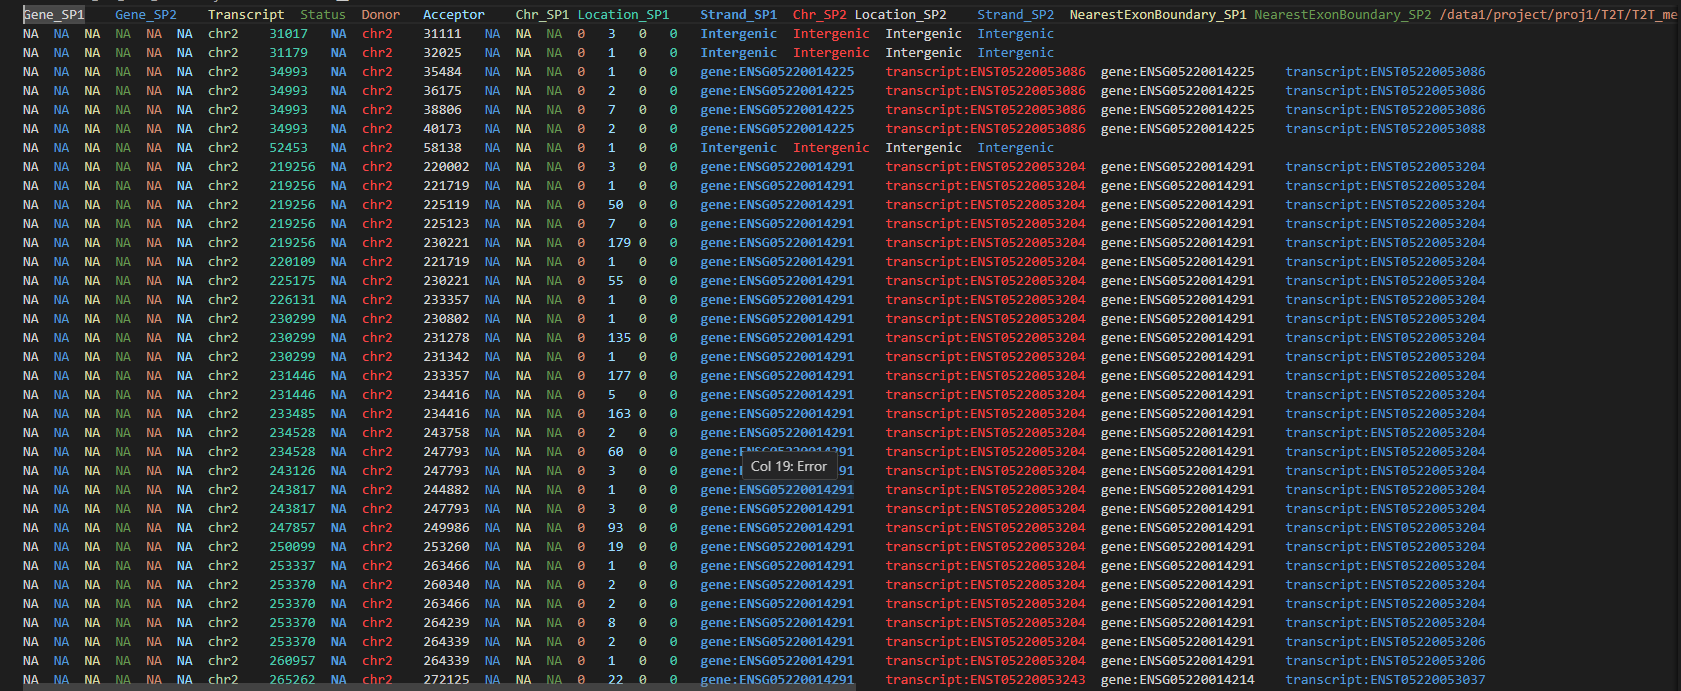

In [23]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_jcounts_file(file_path, k_values=[1, 5, 10, 50]):
    """
    处理 jcounts 文件，统计满足条件的基因数量
    :param file_path: jcounts 文件路径
    :param k_values: 阈值列表，默认为 [1, 5, 10, 50]
    :return: 统计结果字典
    """
    # 读取 jcounts 文件
    jcounts_df = pd.read_csv(file_path, sep='\t',header=0)
    
    # 获取统计列索引（15-18列，索引为14-17）
    stat_columns = jcounts_df.columns[14:18]
    
    # 获取基因ID列索引（倒数第2列和倒数第4列）
    gene_id_col1 = jcounts_df.columns[-2]  # 倒数第2列
    gene_id_col2 = jcounts_df.columns[-4]  # 倒数第4列
    
    # 初始化结果字典
    results = {}
    
    # 对每个阈值k进行处理
    for k in k_values:
        k_results = {}
        
        # 对每个统计列进行处理
        for col in stat_columns:
            # 创建基因计数器
            gene_counter = defaultdict(list)
            
            # 遍历每一行
            for _, row in jcounts_df.iterrows():
                # 获取当前统计列的值
                count_value = row[col]
                
                # 获取基因ID
                gene_id1 = row[gene_id_col1]
                gene_id2 = row[gene_id_col2]
                
                # 处理第一个基因ID
                if pd.notna(gene_id1) and gene_id1 != "NA" and gene_id1 != "Intergenic":
                    gene_counter[gene_id1].append(count_value)
                
                # 处理第二个基因ID
                if pd.notna(gene_id2) and gene_id2 != "NA" and gene_id2 != "Intergenic" and gene_id2 != gene_id1:
                    gene_counter[gene_id2].append(count_value)
            
            # 统计满足条件的基因数量
            valid_genes = 0
            for gene_id, counts in gene_counter.items():
                # 检查是否满足两个条件：
                # 1. 出现行数 >= 2
                # 2. 只要有2行出现的行都 >= k
                if len(counts) >= 2 and sum(1 for c in counts if c >= k) >= 2:
                    valid_genes += 1
            
            k_results[col] = valid_genes
        
        results[k] = k_results
    
    return results

def main():
    # 文件路径
    jcounts_file = "/data1/project/proj1/result/T2T_T2T_exon_counts.txt.jcounts.annotated"
    
    # 处理文件
    results = process_jcounts_file(jcounts_file)
    
    # 打印结果
    for k, k_results in results.items():
        print(f"\n阈值 k = {k}:")
        for col, count in k_results.items():
            print(f"  列 {col}: {count} 个基因满足条件")

if __name__ == "__main__":
    main()


阈值 k = 1:
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr18.bam: 275 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr2.bam: 1283 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr7.bam: 931 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chrY.bam: 53 个基因满足条件

阈值 k = 5:
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr18.bam: 182 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr2.bam: 887 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr7.bam: 656 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chrY.bam: 25 个基因满足条件

阈值 k = 10:
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr18.bam: 156 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr2.bam: 755 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr7.bam: 560 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chrY.bam: 21 个基因满足条件

阈值 k = 50:
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr18.bam: 78 个基因满足条件
  列 /data1/project/proj1/T2T/T2T_merged_sorted_chr2.bam: